#**Описание задачи от клиента.**

Сервис по подбору репетиторов - Repetit.ru получает большое количество заявок от клиентов,желающих найти репетитора. При создании заявки клиент оставляет данные о предмете, желаемой стоимости, возрасте ученика, цели занятий и тд. Т.к. 7 из 8 заявок не доходят до оплаты, то применяется обработка заявки консультантами, что увеличивает конверсию в оплату на 30%.

##**Задача проекта.**


Необходимо разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом. Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет.

**Оценка достигнутого результата.**

Оценка качества модели будет производиться с использованием precision и ROC-AUC.

**Описание данных.**



- teachers_info.feather - *полная информация о репетиторах.*
- suitable_teachers.feather - *подходящие по фильтру репетиторы.*
- orders.feather - *заявки клиентов.*
- prefered_teachers_order_id.feather - *выбранные клиентом репетиторы.*

##**Этапы подготовки проекта для клиента. (План работы)**

1. Знакомство с данными:

- Загрузка данных.
 - Проверка на дубликаты, аномалии, пропуски.
 - Изменение типа данных.
 - Выявление целевого признака.

2. Предобработка данных:

- Объединение датафреймов.
- Работа с дубликатами, аномалиями, пропусками после объединения в единый датафрейм.

3. Работа с признаками.

- EDA (типичный портрет пользователя,исследование баланса, динамика).
- Проверка данных на мультиколлениарность. Удаление лишних признаков. Создание дополнительных признаков без мультиколлениарности.
- Разделение датасета на выборки.
- Проведения масштабирования количественных данных и кодирование категориальных признаков.

4. Обучение модели:

- Подбор гиперпараметров, обучение моделей.
- Выбор лучшей модели по метрике ROC-AUC и времени предсказания.
Итоговый анализ важности признаков, прибыли и издержек по итоговой модели.

5. Отчет о проделанной работе и рекомендации заказчику.

#**Знакомство с данными**

In [1]:
%%capture
# Проведём загрузку необходимых библиотек.
!pip install -q phik
!pip install -q pyfiglet
!pip install -q missingno
!pip install -q gdown
!pip install -q optuna
!pip install -q catboost
!pip install -U scikit-learn

from google.colab import drive

# Импортируем библиотеки для вывода данных.
from pprint import pprint
from IPython.display import display
import pyfiglet
from pyfiglet import Figlet

f_style = Figlet(font="5lineoblique")

# Импортируем библиотеки для вывода графиков.
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set()
plt.style.use("dark_background")
from pylab import rcParams

params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (15, 5),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "figure.autolayout": True,
    "axes.titlepad": 20,
}
rcParams.update(params)

# Импортируем библиотеки для анализа данных.
import pandas as pd


# Настройка, чтобы текст в ячейке отображался весь.
pd.set_option("display.max_colwidth", None)
# Настроим 2 знака после точки в float и разделение запятой тысячные до запятой.
pd.set_option("display.float_format", "{:,.2f}".format)
# Уберем сообщения об ошибке -цепного присваивания.
pd.options.mode.chained_assignment = None
# Увеличим количество вывода колонок и строк.
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
import numpy as np
from scipy import stats as st
import math
import itertools
import operator
from collections import Counter
import re
import missingno as msno
import time

# Импортируем библиотеки для обучения модели.
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    AdaBoostClassifier,
)
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV
)
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, TransformerMixin
import optuna
from optuna.distributions import (
    FloatDistribution as floatd,
    IntDistribution as intd,
    CategoricalDistribution as catd,
)
from optuna.integration import OptunaSearchCV as oscv
from catboost import CatBoostClassifier as catbc
from lightgbm import LGBMClassifier as lgbmc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore")
from sklearn.exceptions import FitFailedWarning

# для создания конструктора модели+кодировка.
from sklearn.compose import (
    make_column_selector,
    ColumnTransformer,
    make_column_transformer
)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# Библиотека для работы с мультиколлениарностью признаков.
import phik
from phik import resources, report

# Библиотека для загрузки данных.
import gdown

In [2]:
# Зафиксируем переменную для разделения на выборки.

RANDOM_STATE = 13022024

In [3]:
# Создадим переменную для фиксации заглушек.

FLAG = {}

In [4]:
# Создадим переменные с адресами и названиями датафремов.

file_list = ["teachers_info", "suitable_teachers", "orders", "prefered_teachers_order_id"]
file_type = ".feather"
path = "https://drive.google.com/drive/" "folders/1Go_Fah4eI9nQcgayTOqaj-ax6NUUx1vm"
g_path = "/content/Repetit_project/"

In [5]:
!mkdir Repetit_project

In [6]:
# Загрузим дублирующий путь к файлам.
try:
  gdown.download_folder(path, quiet=True, use_cookies=False)
except Exception as e:
  drive.mount('/content/gdrive')
  !cp -r /content/gdrive/MyDrive/Repetit_project/* Repetit_project

Mounted at /content/gdrive


In [7]:
# С помощью функции globals создадим переменные для прочитанных датафреймов.

for m in file_list:
  globals()[m] = pd.read_feather(g_path + m  + file_type)

In [8]:
# Создадим копии полученных датафреймов.


for k in file_list:
    globals()[k + "_copy"] = globals()[k].copy()

In [9]:
list(globals())

['__name__',
 '__doc__',
 '__package__',
 '__loader__',
 '__spec__',
 '__builtin__',
 '__builtins__',
 '_ih',
 '_oh',
 '_dh',
 'In',
 'Out',
 'get_ipython',
 'exit',
 'quit',
 '_',
 '__',
 '___',
 '_i',
 '_ii',
 '_iii',
 '_i1',
 '_exit_code',
 'drive',
 'pprint',
 'display',
 'pyfiglet',
 'Figlet',
 'f_style',
 'plt',
 'sns',
 'rcParams',
 'params',
 'pd',
 'np',
 'st',
 'math',
 'itertools',
 'operator',
 'Counter',
 're',
 'msno',
 'time',
 'roc_auc_score',
 'roc_curve',
 'confusion_matrix',
 'classification_report',
 'RandomForestClassifier',
 'VotingClassifier',
 'AdaBoostClassifier',
 'XGBClassifier',
 'SelectKBest',
 'f_classif',
 'RFE',
 'train_test_split',
 'StratifiedKFold',
 'RandomizedSearchCV',
 'shuffle',
 'BaseEstimator',
 'TransformerMixin',
 'optuna',
 'floatd',
 'intd',
 'catd',
 'oscv',
 'catbc',
 'lgbmc',
 'LogisticRegression',
 'DecisionTreeClassifier',
 'warnings',
 'FitFailedWarning',
 'make_column_selector',
 'ColumnTransformer',
 'make_column_transformer',
 'Pip

In [10]:
# Присвоим имена датафреймам.


teachers_info.name = "teach_info"
suitable_teachers.name = "suit_teach"
orders.name = "order"
prefered_teachers_order_id.name = "pref_teach"


In [11]:
# Создадим класс для объединения необходимых функций.
class EDA:
    """Класс для ознакомления с данными."""

    def __init__(self, frame):
        """Функция для инициации атрибута -датафрейма."""
        self.frame = frame

    def first_inf(self):
        """Функция для вывода описания данных."""
        print(f_style.renderText(f"{self.frame.name}"))
        print(f'{"*"*10}Случайные 5 строк датафрейма{"*"*10}\n\n')
        display((self.frame).sample(5))
        print(f'\n\n{"*"*10}Количество колонок и тип данных{"*"*10}\n\n')
        pprint(self.frame.info())
        print(f'\n\n{"*"*10}Описание датафрейма{"*"*10}\n\n')
        display(self.frame.describe(include="all", datetime_is_numeric=True))
        print(
            f'\n\n{"*"*10}Обзор данных после сортировки на наличие аномалий{"*"*10}\n\n'
        )
        for col in self.frame.columns.tolist():
            if self.frame[col].nunique() > 10:
                print(
                    f"\n\n{col} --->\nпервые 5 значений {self.frame[col].sort_values().unique()[:5]}\n\n",
                    f"последние 5 значений {self.frame[col].sort_values().unique()[-5:]}",
                )
            else:
                print(
                    f"\n\n{col} --->\nколонка с менее 10 уникальных значений {self.frame[col].unique()}\n\n"
                )
        print(f'\n\n{"*"*10}Пропуски{"*"*10}\n\n')
        print("Матрица пропусков данных")
        msno.matrix(self.frame)
        plt.show()
        na_filter = (self.frame).isna().any().any()
        if na_filter:
            for col in self.frame.columns:
                print(
                    f"{col}----->{(self.frame[col].isna().sum())}"
                    f" пропусков, доля составляет {(self.frame[col].isna().sum() / self.frame.shape[0]).round(2)}\n\n"
                )
        else:
            print("\n\nПропуски не обнаружены\n\n")
        print("\n\n*********Дубликаты*********\n\n")
        print(f"Количество дубликатов ----> {self.frame.duplicated().sum()}")

    def category_type(self):
        """Функция для изменения типа данных в категориальных колонках."""
        list_category = []
        for col in self.frame.columns.tolist():
            if self.frame[col].nunique() < 10 and self.frame[col].dtype == "O":
                list_category.append(col)
        category_inf = dict(zip(list_category, ["category"] * len(list_category)))
        new_frame = self.frame.astype(category_inf)
        return new_frame



##Таблица данных 'teachers_info'

                                                                               
                                                                               
                                                                   //  ) )     
 __  ___  ___      ___      ___     / __             ( )   __   __//__  ___    
  / /   //___) ) //   ) ) //   ) ) //   ) )         / / //   ) ) //   //   ) ) 
 / /   //       //   / / //       //   / /         / / //   / / //   //   / /  
/ /   ((____   ((___( ( ((____   //   / /   _____ / / //   / / //   ((___/ /   

**********Случайные 5 строк датафрейма**********




,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
289366,293998,2023-05-20 08:50:39.673,2023-05-20 08:44:03.497,1995-03-10 00:00:00.000,2018-09-01 00:00:00.000,1197566,0,0,0,NaN,60,0,5,NaN,NaN,NaN,0,0,7,NaN,0,NaN,60,0,5,NaN,NaN,NaN,0,0,7,NaN,0,NaN,60,0,5,NaN,NaN,NaN,0,0,7,NaN,NaN,0,1,1,0,NaN,2023-05-20 08:44:03.497,NaN,NaN,0,0.00,9,NaN,1,0,0,NaN,1,1,1,0.00,0.00,NaN,0,0,0.00,0,NaN,NaN,4.30,0.00,0,2023-05-20 08:44:03.497,1,NaN,NaN
133058,136453,2023-01-19 01:19:53.400,2018-01-09 12:37:05.000,1993-10-18 00:00:00.000,2015-09-01 00:00:00.000,322700,0,1,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,"[p]- Изучаю английский язык на протяжении 15 лет (до университета посещала курсы Mr.English и English First).[/p][p]- Владею языком на уровне Upper Intermediate/Advanced.[/p][p]- Имею 3-летний опыт работы репетитором.[/p][p]- Имею опыт общения с носителями языка, а также сотрудничества и переговоров в рамках основной работы.[/p][p]- Гарантирую индивидуальный подход к каждому ученику.[/p][p]За что берусь:[/p][p]- Ученики младшей, средней, старшей школы[/p][p]- Освоение грамматики, фонетики, лексики[/p][p]- Освоение и развитие устной речи[/p][p]- Помощь с выполнением домашнего задания[/p][p]- Общее поддержание уровня языка[/p][p]- Повышение уровня языка (работа на опережение школьной программы,более глубокое и детальное изучение языка. Зачастую, тех знаний, что дают в школе по английскому языку, недостаточно. Если Вашему ребенку интересен английский язык, а также будет необходим в будущем (например, сопряжен с профессией), то этот пункт для Вас).[/p]",1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,"[p]- Изучаю английский язык на протяжении 15 лет (до университета посещала курсы Mr.English и English First).[/p][p]- Владею языком на уровне Upper Intermediate/Advanced.[/p][p]- Имею 3-летний опыт работы репетитором.[/p][p]- Имею опыт общения с носителями языка, а также сотрудничества и переговоров в рамках основной работы.[/p][p]- Гарантирую индивидуальный подход к каждому ученику.[/p][p]За что берусь:[/p][p]- Ученики младшей, средней, старшей школы[/p][p]- Освоение грамматики, фонетики, лексики[/p][p]- Освоение и развитие устной речи[/p][p]- Помощь с выполнением домашнего задания[/p][p]- Общее поддержание уровня языка[/p][p]- Повышение уровня языка (работа на опережение школьной программы,более глубокое и детальное изучение языка. Зачастую, тех знаний, что дают в школе по английскому языку, недостаточно. Если Вашему ребенку интересен английский язык, а также будет необходим в будущем (например, сопряжен с профессией), то этот пункт для Вас).[/p]",1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/136453/photo/photo_small.webp,"[p]- Изучаю английский язык на протяжении 15 лет (до университета посещала курсы Mr.English и English First).[/p][p]- Владею языком на уровне Upper Intermediate/Advanced.



**********Количество колонок и тип данных**********


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  st

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
count,"307,972.00",307972,307972,307972,307972,"307,972.00","307,972.00","307,972.00","307,972.00",90978,"307,972.00","307,972.00","307,972.00",46379,"14,873.00","6,543.00","307,972.00","307,972.00","307,972.00",132972,"307,972.00",90978,"307,972.00","307,972.00","307,972.00",46379,"14,873.00","6,543.00","307,972.00","307,972.00","307,972.00",132972,"307,972.00",90978,"307,972.00","307,972.00","307,972.00",46379,"14,873.00","6,543.00","307,972.00","307,972.00","307,972.00",185484,132972,"307,972.00","307,972.00","307,972.00","307,972.00",44940,307972,235837,"11,208.00","307,972.00","307,972.00","307,972.00",29928,"307,972.00","307,972.00","307,972.00",6043,"307,972.00","307,972.00","307,972.00","307,972.00","307,972.00","1,323.00","307,972.00","307,972.00","307,972.00","307,972.00","78,418.00",47734,"307,972.00","307,972.00","307,972.00",307972,"307,972.00","24,902.00",1705
unique,NaN,307079,307729,22247,776,NaN,NaN,NaN,NaN,26082,NaN,NaN,NaN,1575,NaN,NaN,NaN,NaN,NaN,121897,NaN,26082,NaN,NaN,NaN,1575,NaN,NaN,NaN,NaN,NaN,121897,NaN,26082,NaN,NaN,NaN,1575,NaN,NaN,NaN,NaN,NaN,179958,121897,NaN,NaN,NaN,NaN,36902,222686,235805,NaN,NaN,NaN,NaN,4571,NaN,NaN,NaN,2602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6062,NaN,NaN,NaN,222907,NaN,NaN,1705
top,NaN,2023-01-18 20:08:30.657,2007-12-24 19:26:46.000,1989-01-01 00:00:00.000,2017-09-01 00:00:00.000,NaN,NaN,NaN,NaN,Ближайший район: Не указано.,NaN,NaN,NaN,2024-06-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА,NaN,Ближайший район: Не указано.,NaN,NaN,NaN,2024-06-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА,NaN,Ближайший район: Не указано.,NaN,NaN,NaN,2024-06-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,/photo/no_photo.png,РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА,NaN,NaN,NaN,NaN,год окончания вуза,2014-08-12 00:00:00.000,2017-01-18 09:40:42.000,NaN,NaN,NaN,NaN,2023-09-01 00:00:00.000,NaN,NaN,NaN,Возможны занятия по Skype.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ya_mow_own_sn_hv,NaN,NaN,NaN,2017-01-01 00:00:00.000,NaN,NaN,2021-10-23 13:04:52.410
freq,NaN,3,134,111,19269,NaN,NaN,NaN,NaN,3201,NaN,NaN,NaN,3105,NaN,NaN,NaN,NaN,NaN,6916,NaN,3201,NaN,NaN,NaN,3105,NaN,NaN,NaN,NaN,NaN,6916,NaN,3201,NaN,NaN,NaN,3105,NaN,NaN,NaN,NaN,NaN,5527,6916,NaN,NaN,NaN,NaN,106,85235,2,NaN,NaN,NaN,NaN,1200,NaN,NaN,NaN,339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6086,NaN,NaN,NaN,84976,NaN,NaN,1
mean,"157,246.18",NaN,NaN,NaN,NaN,"486,159.45",0.01,0.42,0.60,NaN,61.50,532.58,4.18,NaN,inf,inf,0.54,4.24,7.42,NaN,0.89,NaN,61.50,532.58,4.18,NaN,inf,inf,0.54,4.24,7.42,NaN,0.89,NaN,61.50,532.58,4.18,NaN,inf,inf,0.54,4.24,7.42,NaN,NaN,0.89,0.66,10.22,-222.16,NaN,NaN,NaN,0.95,0.01,NaN,8.49,NaN,1.78,0.35,0.51,NaN,0.73,0.80,0.87,NaN,NaN,inf,0.47,0.86,NaN,0.69,0.00,NaN,



**********Обзор данных после сортировки на наличие аномалий**********




id --->
первые 5 значений [33 46 51 52 54]

 последние 5 значений [312618 312619 312620 312621 312622]


date_update --->
первые 5 значений ['2020-11-05 13:52:08.960', '2021-11-06 22:52:20.260', '2021-11-07 09:01:49.563', '2021-11-11 15:27:51.903', '2022-05-31 19:23:42.860']
Categories (307079, object): ['2020-11-05 13:52:08.960', '2021-11-06 22:52:20.260',
                              '2021-11-07 09:01:49.563', '2021-11-11 15:27:51.903', ...,
                              '2023-11-07 14:40:57.440', '2023-11-07 14:40:58.357',
                              '2023-11-07 14:40:58.610', '2023-11-07 14:40:59.987']

 последние 5 значений ['2023-11-07 14:40:57.010', '2023-11-07 14:40:57.440', '2023-11-07 14:40:58.357', '2023-11-07 14:40:58.610', '2023-11-07 14:40:59.987']
Categories (307079, object): ['2020-11-05 13:52:08.960', '2021-11-06 22:52:20.260',
                              '2021-11-07 09:01:49.563', '2021-1

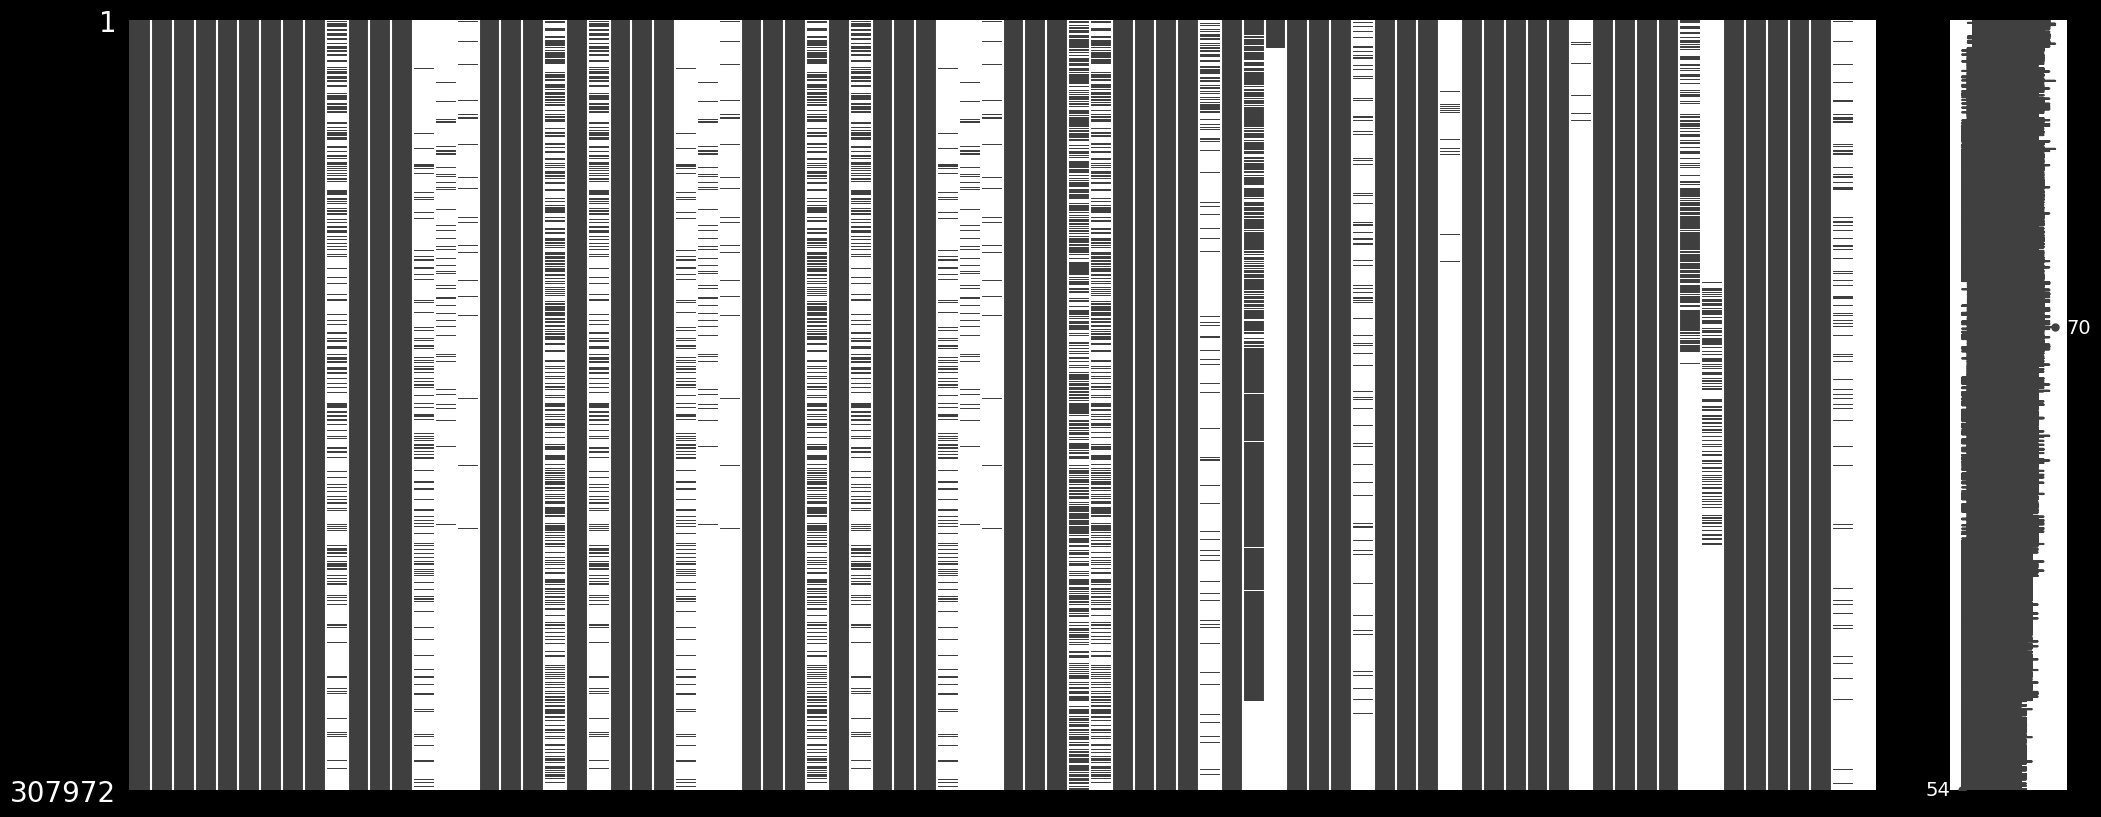

id----->0 пропусков, доля составляет 0.0


date_update----->0 пропусков, доля составляет 0.0


reg_date----->0 пропусков, доля составляет 0.0


birth_date----->0 пропусков, доля составляет 0.0


teaching_start_date----->0 пропусков, доля составляет 0.0


user_id----->0 пропусков, доля составляет 0.0


is_email_confirmed----->0 пропусков, доля составляет 0.0


is_home_lessons----->0 пропусков, доля составляет 0.0


is_external_lessons----->0 пропусков, доля составляет 0.0


external_comments----->216994 пропусков, доля составляет 0.7


lesson_duration----->0 пропусков, доля составляет 0.0


lesson_cost----->0 пропусков, доля составляет 0.0


status_id----->0 пропусков, доля составляет 0.0


status_relevant_date----->261593 пропусков, доля составляет 0.85


status_school_id----->293099 пропусков, доля составляет 0.95


status_college_id----->301429 пропусков, доля составляет 0.98


status_display----->0 пропусков, доля составляет 0.0


russian_level_id----->0 пропусков, доля составляет 0

In [12]:
# Создадим экземпляр класса и применим к нему функции.

teach_info = EDA(teachers_info)
teach_info.first_inf()

In [13]:
# Подтвердим теорию о том, что в датасете есть дублирующиеся колонки.

columns_duplicate = []


for k in range(len(teachers_info.columns.tolist())):
  for m in range(k+1, len(teachers_info.columns.tolist())):
    if teachers_info[teachers_info.columns.tolist()[k]].equals(teachers_info[teachers_info.columns.tolist()[m]]):
      columns_duplicate.append(teachers_info.columns.tolist()[m])
      print (f'{teachers_info.columns.tolist()[k]} ***** vs ***** {teachers_info.columns.tolist()[m]}')

external_comments ***** vs ***** external_comments.1
external_comments ***** vs ***** external_comments.2
lesson_duration ***** vs ***** lesson_duration.1
lesson_duration ***** vs ***** lesson_duration.2
lesson_cost ***** vs ***** lesson_cost.1
lesson_cost ***** vs ***** lesson_cost.2
status_id ***** vs ***** status_id.1
status_id ***** vs ***** status_id.2
status_relevant_date ***** vs ***** status_relevant_date.1
status_relevant_date ***** vs ***** status_relevant_date.2
status_school_id ***** vs ***** status_school_id.1
status_school_id ***** vs ***** status_school_id.2
status_college_id ***** vs ***** status_college_id.1
status_college_id ***** vs ***** status_college_id.2
status_display ***** vs ***** status_display.1
status_display ***** vs ***** status_display.2
russian_level_id ***** vs ***** russian_level_id.1
russian_level_id ***** vs ***** russian_level_id.2
home_country_id ***** vs ***** home_country_id.1
home_country_id ***** vs ***** home_country_id.2
information ***** vs

In [14]:
# Посмотрим на примеры задублированных колонок.

teachers_info[['external_comments', 'external_comments.1', 'external_comments.2']].sample(10)

,external_comments,external_comments.1,external_comments.2
83798,NaN,NaN,NaN
133271,Ближайший район: Ленинский район.,Ближайший район: Ленинский район.,Ближайший район: Ленинский район.
291934,NaN,NaN,NaN
79826,Ближайший район: м. Гражданский проспект. Выезд: в пешей доступности от станции метро.,Ближайший район: м. Гражданский проспект. Выезд: в пешей доступности от станции метро.,Ближайший район: м. Гражданский проспект. Выезд: в пешей доступности от станции метро.
158545,NaN,NaN,NaN
182077,NaN,NaN,NaN
44948,NaN,NaN,NaN
48978,NaN,NaN,NaN
195678,NaN,NaN,NaN
139077,NaN,NaN,NaN


In [15]:
# Выведем список задублированных колонок.

pprint(columns_duplicate)

['external_comments.1',
 'external_comments.2',
 'lesson_duration.1',
 'lesson_duration.2',
 'lesson_cost.1',
 'lesson_cost.2',
 'status_id.1',
 'status_id.2',
 'status_relevant_date.1',
 'status_relevant_date.2',
 'status_school_id.1',
 'status_school_id.2',
 'status_college_id.1',
 'status_college_id.2',
 'status_display.1',
 'status_display.2',
 'russian_level_id.1',
 'russian_level_id.2',
 'home_country_id.1',
 'home_country_id.2',
 'information.1',
 'information.2',
 'is_confirmed.1',
 'is_confirmed.2',
 'external_comments.2',
 'lesson_duration.2',
 'lesson_cost.2',
 'status_id.2',
 'status_relevant_date.2',
 'status_school_id.2',
 'status_college_id.2',
 'status_display.2',
 'russian_level_id.2',
 'home_country_id.2',
 'information.2',
 'is_confirmed.2']


In [16]:
# Удалим дубликаты колонок.

teachers_info.drop(columns_duplicate, axis=1, inplace=True)

### Работа с датами.

In [17]:
# Удалим колонки, в которых большое количество пропусков, а так же из-за того ,что они содержат нерелевантные для нашей задачи данные.

teachers_info.drop(['status_relevant_date','pupil_needed_date'], axis=1,inplace=True)

In [18]:
# Создадим списки колонок с пропусками и без

date_teach = teachers_info.head(0).T
date_transfer = date_teach[date_teach.index.str.contains('date')].index.tolist()
date_transfer.append('last_visited')
date_no_na = []
date_with_na =[]

for col in date_transfer:
  if not teachers_info[col].isna().any().any():
    date_no_na.append(col)
  else:
    date_with_na.append(col)


In [19]:
# Установим последний день - 2023-11-07, полученный в результате анализа предоставленных данных.

LAST_DAY = pd.to_datetime('2023-11-07', format='%Y-%m-%dT')

#


teachers_info['last_visited'] = pd.to_datetime(teachers_info['last_visited'], errors='coerce')

In [20]:
# Удалим колонку.

teachers_info.drop('free_time_relevance_date',axis=1,inplace=True)

In [21]:
teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 53 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   id                          307972 non-null  int32         
 1   date_update                 307972 non-null  category      
 2   reg_date                    307972 non-null  category      
 3   birth_date                  307972 non-null  category      
 4   teaching_start_date         307972 non-null  category      
 5   user_id                     307972 non-null  int32         
 6   is_email_confirmed          307972 non-null  int8          
 7   is_home_lessons             307972 non-null  int8          
 8   is_external_lessons         307972 non-null  int8          
 9   external_comments           90978 non-null   category      
 10  lesson_duration             307972 non-null  int16         
 11  lesson_cost                 307972 non-

In [22]:
# Заполним пропуски в данных датой 2023-11-07.

FLAG['teachers_info'] = {'2023-11-07':['last_visited']}

teachers_info['last_visited'].fillna(LAST_DAY, inplace = True)
print(teachers_info['last_visited'].isna().any().any())

False


In [23]:
date_transfer = [k for k in date_transfer if k not in ['free_time_relevance_date']]

for col in date_transfer:
    teachers_info[col] = pd.to_datetime(teachers_info[col] , format='%Y-%m-%dT').dt.date

In [24]:
# Приведем колонки с датами без пропусков к типу данных - 'datetime64[ns]'.

teachers_info[date_transfer] = teachers_info[date_transfer].apply(pd.to_datetime,format='%Y-%m-%dT')

In [25]:
# Создадим функцию для расчета количества лет.

def num_years(start_date: pd.Timestamp, end_date: pd.Timestamp) -> float:
    """
    Функция расчитывает количество лет между двумя датамию
    :param start_date: Start date as Pandas Timestamp
    :param end_date: End date as Pandas Timestamp
    :return: float representing the number of years
    """
    try:
      start_year = start_date.year
      start_month = start_date.month
      start_day = start_date.day
    except AttributeError as a:
      start_year = start_date.apply(lambda x: x.year)
      start_month = start_date.apply(lambda x: x.month)
      start_day = start_date.apply(lambda x: x.day)


    try:
      end_year = end_date.year
      end_month = end_date.month
      end_day = end_date.day
    except AttributeError as a:
      end_year = end_date.apply(lambda x: x.year)
      end_month = end_date.apply(lambda x: x.month)
      end_day = end_date.apply(lambda x: x.day)


    try:
        years = end_year - start_year
        if end_month < start_month.all():
           years-=1
        if (end_month == start_month.all()) & (end_day < start_day.all()):
           years-=1
    except (AttributeError, ValueError) as a:
        years = end_year - start_year
        if end_month.all() < start_month.all():
           years-=1
        if (end_month.all() == start_month.all()) & (end_day.all() < start_day.all()):
           years-=1


    return years

In [26]:
# Создадим колонки с расчетом разницы в датах.

for col in (date_transfer):
    teachers_info[col+'_numb'] = num_years(teachers_info[col], LAST_DAY)

In [27]:
# Убедимcя, что новые колонки созданы.

teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 60 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   id                          307972 non-null  int32         
 1   date_update                 307972 non-null  datetime64[ns]
 2   reg_date                    307972 non-null  datetime64[ns]
 3   birth_date                  307972 non-null  datetime64[ns]
 4   teaching_start_date         307972 non-null  datetime64[ns]
 5   user_id                     307972 non-null  int32         
 6   is_email_confirmed          307972 non-null  int8          
 7   is_home_lessons             307972 non-null  int8          
 8   is_external_lessons         307972 non-null  int8          
 9   external_comments           90978 non-null   category      
 10  lesson_duration             307972 non-null  int16         
 11  lesson_cost                 307972 non-

In [28]:
# Удалим колонки с датами.

teachers_info.drop(date_transfer,axis=1,inplace=True)

In [29]:
# Посмотрим на колонку - date_update_numb.

teachers_info.date_update_numb.value_counts(normalize = True).to_frame()

,date_update_numb
0,1.00
1,0.00
2,0.00
3,0.00


In [30]:
# Удалим колонку.

teachers_info.drop('date_update_numb',axis=1,inplace=True)

### Работа с категорийными данными.

**photo_path**

In [31]:
# Создадим новую категорию и заполним все пропуски 0 значением

teachers_info['photo_path'] = teachers_info['photo_path'].cat.add_categories([0])
teachers_info['photo_path'] = teachers_info['photo_path'].cat.add_categories([1])
teachers_info['photo_path'].fillna(0, inplace= True)
FLAG['teachers_info'] = {'2023-11-07':date_with_na,'0':['photo_path']}

In [32]:
# Посмотрим на количество дублирующихся значений.

teachers_info.query('photo_path.notna().duplicated()')['photo_path'].value_counts().to_frame()

,photo_path
0,122488
/photo/no_photo.png,5527
/teachers/290998/photo/photo_small.jpg,1
/teachers/290983/photo/photo_small.jpg,1
/teachers/290985/photo/photo_small.jpg,1
...,...
/teachers/199515/photo/photo_small.webp,1
/teachers/199516/photo/photo_small.webp,1
/teachers/199518/photo/photo_small.jpg,1
/teachers/33/photo/photo_small.jpg,0


In [33]:
# Заполним 5527 дубликатов с одинаковыми значениями 0.

teachers_info.loc[teachers_info['photo_path'] == "/photo/no_photo.png",'photo_path'] = 0

In [34]:
# Убедимяся, что оставшиеся значения колонки содержат названия файлов с расширениями.


display(teachers_info.photo_path.str.contains(r'\b.[a-z]{3,4}').value_counts().to_frame())
print('\n\n\n')
teachers_info.photo_path.str.findall(r'\b\.[a-z]{3,4}').value_counts().to_frame()

,photo_path
True,179957


,photo_path
[.webp],151738
[.jpg],26333
[.png],1882
[.jpeg],3
[.bmp],1


In [35]:
# Заполним строки содержащие пути на реальные фото - 1.

teachers_info.loc[teachers_info['photo_path'] != 0,'photo_path'] = 1

In [36]:
# Удалим ненужные категории.

teachers_info['photo_path'] = teachers_info.photo_path.cat.remove_unused_categories()

In [37]:
# Посмотрим на значения колонки после обработки.

teachers_info['photo_path'].value_counts().to_frame()

,photo_path
1,179957
0,128015


**information**

In [38]:
# Посмотрим на количество дублирующихся значений.

teachers_info.query('information.notna()')['information'].value_counts().to_frame()

,information
РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА,6916
[p]РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА[/p],192
Действующий школьный преподаватель.,154
Опыт работы в школе.,152
\n,115
...,...
"[p]Магистр психологии, педагог-психолог, эксперт- психолог, автор общеразвивающих, коррекционно-развивающих программ для детей 3-7 лет с нормативным и отклоняющимся развитием ( детей с сохранённым интеллектом) . Руководитель центра развития детей и взрослых. Опыт работы с 2010 года.[/p][p]За 2022 год подготовлено 42 победителя Всероссийских, Международных образовательных олимпиад для дошкольников (из них 25% - дети с дефицитами развития, 25% - дети-инвалиды. [/p]",1
"[p]Магистр психологии по направлению «Прикладной психоанализ, психоаналитический коучинг и бизнес-консультирование» Департамента психологии НИУ ВШЭ.[/p][p]Психоаналитически ориентированный психотерапевт и коуч.[/p][p]Карьерный консультант.Психодинамический организационный консультант. Член Ассоциации психоаналитического коучинга и бизнес-консультирования (АПКБК).[/p][p]Работаю преимущественно в психодинамическом подходе, владею методами диагностики из клинической психологии.[/p][p]Работаю с самыми разными запросами:[/p][p]— понимание собственных бессознательных конфликтов и, как следствие, причин эмоциональных и поведенческих затруднений;— непосредственно психологическое консультирование [/p][p]— краткосрочная психологическая помощь в поиске разрешения в конфликтной ситуации; [/p][p]— психоаналитический коучинг — сфокусирован на бизнех-запросах, вопросах карьеры и работы, достижении целей в сроки.[/p][p]Регулярно супервизирую свою работу у психоаналитически ориентированных, сертифицированных супервизоров.Прохожу личную психотерапию в психоаналитическом методе.[/p][p]Проведение групповых тренингов для сотрудников ГБУ Городской центр профессионального и карьерного развития. Авторский цикл лекций «Психология лидерства» для слушателей Столичной Бизнес Академии. Авторский тренинг для сотрудников организаций «Профессиональное выгорание: как распознать и что делать». Авторский групповой тренинг «Как сменить профессию». Составление психологических портретов.[/p][p]Использую проективные методики:• тематический апперцептивный тест (ТАТ);• методика чернильных пятен Роршаха;• неоконченные предложения Сакса-Леви;• дом, дерево, человек;• рисунок семьи;• пиктограмма;• несуществующее животное;• психодрама;• тест фрустрации Розенцвейга;• метафорические ассоциативные карты (МАК);• организационный рисунок и организационная фотоматрица.[/p][p]Диагностические методы:• психоаналитическое интервью;• структурное интервью Кернберга;• Миннесотский многоаспектный личностный опросник (MMPI);• таблица Шульте;• 16-ти факторный личностный опросник Кеттелла;• шкала депрессии Бека;• 10 слов;• поговорки.[/p][p]Краткосрочные курсы и семинары повышения квалификации:[/p][p]— Манфред Кетс де Вриз — Секреты лидерства: патология лидера в повседневной жизни[/p][p]— Рене Руссийон — Символизация: различные уровни и формы[/p][p]— Руджеро Леви — Особенности психоаналитической работы с подростками[/p][p]— Екатерина Михайлова — Психодрама: за пределами классики[/p][p]— Леонид Кроль — Групповой коучинг[/p][p]— Станислав Раевский — Комплексная психология и психотерапия: 7 базовых комплексов[/p][p]— Марина Мелия — Executive коучинг[/p][p]— Лявас Коварскис — Основы практической работы психотерапевта: основные инструменты[/p][p]— Наталия Долина — Раскрытие и управление личной силой — основа эффективности и развития; Построение личной карты успеха[/p][p]— Жильбер Дяткин — Самоанализ аналитика и пациента[/p][p]— Марша Рейнольдс — Сила присутствия при катализации изменений [/p][p]— Алан Жибо — Первичное интервью в невротической, пограничной и психотической структуре[/p][p]— 5 Юбилейный Российско-Германский коллоквиум: Люди ищут смыслы[/p][p]— Татьяна Дремлюга — Этапы работы и подводные камни в работе с клиентами и организациями[/p][p]— Марк Кукушкин — Корпоративная культура: исследование и трансформация[/p][p]— Мартин Рингер — Групповая психодинамика 

In [39]:
# Посмотрим,сколько регистраций репетиторов не было завершено.

teachers_info.query('information.notna()')[teachers_info.query('information.notna()')['information'].str.lower().str.contains(r'регистрация не была')]['information'].value_counts()[lambda x:x>0].to_frame()

,information
РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА,6916
[p]РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА[/p],192
[p]&nbsp;[/p][p]РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА[/p][p]&nbsp;[/p],1


In [40]:
# Удалим незарершенные регистрации.

teach_del_info_rows = teachers_info.query('information.notna()')[teachers_info.query('information.notna()')['information'].str.lower().str.contains(r'регистрация не была')]['information'].index.to_list()
teachers_info.drop(teach_del_info_rows,axis = 0, inplace = True)

**comments**

In [41]:
# Посмотрим на количество уникальных значений колонки.

teachers_info.query('comments.notna()')['comments'].value_counts().to_frame()

,comments
год окончания вуза,106
нет отчества,85
Не является ИП.,39
\n,30
Репетитор не указала отчество - отправлено письмо.,28
...,...
132848,0
101635,0
101642,0
Дубль 128228,0


In [42]:
# Посмотрим на количество дублей в регистрации.

teachers_info.query('comments.notna()')[teachers_info.query('comments.notna()')['comments'].str.contains(r'дубль|\d{6}')]['comments'].value_counts()[lambda x:  (x > 1)].to_frame()

,comments
дубль,26
194904 194905 194906 194907 194908 194909 194910 194911 194912 194913 194914 194915 194916 194917 194918 194919 194920 194921 194922 194923,16
дубль,9
146173 172351 172352 172354 172355 172356 172357 172358 172359 172361,6
194904 194905 194906 194907 194908 194909 194910 194911 194912 194913 194914 194915 194916 194917 194918 194920 194921 194922 194923 194924,6
...,...
дубль 4200,2
235021,2
182114,2
140013,2


In [43]:
# Создадим список с значениями содержащими либо слово "дубль", либо номер заявки от репетитора.

teach_del_comm_rows = teachers_info.query('comments.notna()')[teachers_info.query('comments.notna()')['comments'].str.contains(r'дубль|\d{6}')]['comments'].value_counts()[lambda x:  (x > 1)].to_frame().index.to_list()

In [44]:
# Посмотрим на получившийся список значений.

teach_del_comm_rows

['дубль ',
 '194904 194905 194906 194907 194908 194909 194910 194911 194912 194913 194914 194915 194916 194917 194918 194919 194920 194921 194922 194923',
 'дубль',
 '146173 172351 172352 172354 172355 172356 172357 172358 172359 172361',
 '194904 194905 194906 194907 194908 194909 194910 194911 194912 194913 194914 194915 194916 194917 194918 194920 194921 194922 194923 194924',
 'зарегистрировал дубль с фамилией Скоровский - 228766.\n197057 и 192755 тоже он 195838\nи 160074, 192755, 197403, 208863, 197057, 165116,180504, 169551, 180506, 222634, 225697, 226965 (Кузнецова 16.06.21)',
 '194803 194804 194904 194905 194906 194907 194908 194909 194910 194911 194912 194913 194914 194915 194916 194917 194918 194919 194920 194921 194922 194923 194924 194925 194926 194927 194928 194929 194930 194931 194932 194933 194934 194937 194938 194939 194940 194941 194942 194943 194944 194945 194946 194947 194948 194949 194950 194951 194952 194953 194954 194955 194956 194957 194958 194959 194960 194961 1

In [45]:
# Создадим список индексов дубликатов.


teach_del_comm_index = []

for k in teach_del_comm_rows:
  if len(teachers_info.query('comments.notna()')[teachers_info.query('comments.notna()')['comments'].str.contains(k)]['comments']) > 0:
    list_comm_index = teachers_info.query('comments.notna()')[teachers_info.query('comments.notna()')['comments'].str.contains(k)]['comments'].index.to_list()
    teach_del_comm_index.append(list_comm_index)


In [46]:
# Распакуем список списков.

teach_del_comm = [k for m in teach_del_comm_index for k in m]

In [47]:
# Убедимя в результате.

teachers_info['comments'][teach_del_comm].to_frame()

,comments
155,"26.02.2008 Отправлено письмо: ""Уточнения в анкете""\r\n20.04.2008 Анкета заблокировна как неактивная.\r\nдубль 8175"
159,"26.02.2008 Отправлено письмо: ""Уточнения в анкете""\r\n20.04.08 Отправлены конкретные вопросы по анкете (Людмила)\r\nдубль 10181"
311,"10.02.08 Анкета проверена с преподавателем (Людмила)\r\nдубль 2425 - ошибка наша, анкета закрыта"
627,05.04.08 Не отвечает телефон. Отправлено письмо (Людмила)\r\nдубль 13653
687,"21.04.08. В течение недели не дозвонилась, отправлено письмо (Людмила)\r\nдубль 12178"
...,...
206858,182114
181562,140013
201647,140013
6416,дубль 6400


In [48]:
# Удалим строки.

teachers_info.drop(teach_del_comm, axis = 0, inplace = True)

In [49]:
# Взглянем на колонки с категориями.

teachers_info.select_dtypes(include = 'category').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296981 entries, 0 to 307971
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   external_comments  89090 non-null   category
 1   information        124355 non-null  category
 2   photo_path         296981 non-null  category
 3   comments           40619 non-null   category
 4   remote_comments    5879 non-null    category
 5   partner_id         43350 non-null   category
dtypes: category(6)
memory usage: 14.2 MB


In [50]:
# Удалим колонки с тектовыми данными, т.к. вся необходимая информация учтена.

teachers_info.drop(['partner_id','remote_comments','information','external_comments','comments'],axis = 1, inplace = True)

In [51]:
# Создадим список колонок ,где количество уникальных значений менее или равно 5.

bool_columns = []

for col in teachers_info.select_dtypes(exclude=['category']).columns.tolist():
  if len(teachers_info[col].unique()) <= 5:
    bool_columns.append(col)
    print(f'**********{col}**********')
    print (teachers_info[col].value_counts(normalize = True))
    print (teachers_info[col].isna().sum())
    print (f'{teachers_info[col].duplicated().sum()}\n\n\n')

**********is_email_confirmed**********
0   0.99
1   0.01
Name: is_email_confirmed, dtype: float64
0
296979



**********is_home_lessons**********
0   0.57
1   0.43
Name: is_home_lessons, dtype: float64
0
296979



**********is_external_lessons**********
1   0.61
0   0.39
Name: is_external_lessons, dtype: float64
0
296979



**********status_display**********
1   0.55
0   0.45
Name: status_display, dtype: float64
0
296979



**********is_confirmed**********
1   0.89
0   0.11
Name: is_confirmed, dtype: float64
0
296979



**********is_display**********
1   0.68
0   0.32
Name: is_display, dtype: float64
0
296979



**********is_pupils_needed**********
1.00   0.94
0.00   0.06
Name: is_pupils_needed, dtype: float64
286619
296978



**********is_cell_phone_confirmed**********
0   0.99
1   0.01
Name: is_cell_phone_confirmed, dtype: float64
0
296979



**********sex**********
2   0.75
1   0.25
3   0.00
0   0.00
Name: sex, dtype: float64
0
296977



**********amount_to_pay**********
0     1.00


In [52]:
# Удалим колонки с неинформативными значениями.

teachers_info.drop(['is_email_confirmed','is_cell_phone_confirmed','is_pupils_needed','amount_to_pay'],axis=1,inplace=True)

In [53]:
teachers_info.drop('is_individual',axis=1,inplace=True)

In [54]:
# Посмотрим на колонку - sex.

teachers_info.sex.value_counts().to_frame()

,sex
2,221935
1,73807
3,1237
0,2


In [55]:
# заполним значения в колонке sex равными 3 и 0 - наиболее частым значением - 2

teachers_info.loc[teachers_info['sex'].isin([3,0]),'sex'] = 2

In [56]:
# Обновим получившийся список и посмотрим на dtype.

bool_columns = [k for k in bool_columns if k not in ['is_email_confirmed','is_cell_phone_confirmed','is_pupils_needed','amount_to_pay','is_individual']]
teachers_info[bool_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296981 entries, 0 to 307971
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   is_home_lessons         296981 non-null  int8 
 1   is_external_lessons     296981 non-null  int8 
 2   status_display          296981 non-null  int8 
 3   is_confirmed            296981 non-null  int8 
 4   is_display              296981 non-null  int8 
 5   sex                     296981 non-null  int8 
 6   is_remote_lessons       296981 non-null  int8 
 7   show_on_map             296981 non-null  int8 
 8   send_mailing            296981 non-null  int8 
 9   send_suitable_orders    296981 non-null  int8 
 10  is_edited               296981 non-null  int8 
 11  orders_allowed          296981 non-null  int8 
 12  verification_status_id  296981 non-null  int8 
 13  is_display_at_partners  296981 non-null  int8 
dtypes: int8(14)
memory usage: 6.2 MB


In [57]:
# Изменим тип данных на категорию.

teachers_info[bool_columns] = teachers_info[bool_columns].astype('category')

In [58]:
# Соберем в список колонки содержащие в названии id.

ids = []

for m in teachers_info.select_dtypes(exclude = 'category').columns.to_list():
  if "id" in m:
    ids.append(m)
    print(f'**********{m}**********')
    print (teachers_info[m].value_counts(normalize = True))
    print (teachers_info[m].isna().sum())
    print (f'{teachers_info[m].duplicated().sum()}\n\n\n')

**********id**********
33       0.00
213011   0.00
212991   0.00
212990   0.00
212989   0.00
         ... 
104607   0.00
104606   0.00
104605   0.00
104604   0.00
312622   0.00
Name: id, Length: 296981, dtype: float64
0
0



**********user_id**********
45        0.00
705119    0.00
705050    0.00
705043    0.00
705040    0.00
          ... 
133918    0.00
133910    0.00
133903    0.00
133900    0.00
1334900   0.00
Name: user_id, Length: 296981, dtype: float64
0
0



**********status_id**********
5   0.71
1   0.17
3   0.06
4   0.03
7   0.02
2   0.01
Name: status_id, dtype: float64
0
296975



**********status_school_id**********
3.00       0.10
5.00       0.01
2.00       0.00
1,517.00   0.00
4.00       0.00
           ... 
1,368.00   0.00
1,456.00   0.00
1,520.00   0.00
1,659.00   0.00
8,068.00   0.00
Name: status_school_id, Length: 3590, dtype: float64
282162
293390



**********status_college_id**********
785.00     0.08
2,011.00   0.03
776.00     0.03
815.00     0.02
731.00     0.02


In [59]:
# Удалим колонки с большим количеством пропусков.

teachers_info.drop(['status_school_id', 'status_college_id','passport_id','status_institution_id'],axis=1,inplace=True)

In [60]:
# Обновим получившийся список и посмотрим на dtype.

ids = [k for k in ids if k not in ['status_school_id', 'status_college_id','passport_id','status_institution_id']]
teachers_info[ids].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296981 entries, 0 to 307971
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   id                296981 non-null  int32
 1   user_id           296981 non-null  int32
 2   status_id         296981 non-null  int8 
 3   russian_level_id  296981 non-null  int8 
 4   home_country_id   296981 non-null  int16
 5   rating_id         296981 non-null  int8 
 6   area_id           296981 non-null  int8 
dtypes: int16(1), int32(2), int8(4)
memory usage: 6.2 MB


In [61]:
# Изменим тип данных на категорию.

teachers_info[ids] = teachers_info[ids].astype('category')

### Работа с числовыми данными.

In [62]:
# Посмотрим на оставшиеся колонки.

teachers_info.select_dtypes(exclude = 'category').describe()

,lesson_duration,lesson_cost,rating,effective_rating,rating_for_users,rating_for_admin,display_days,star_rating,rating_for_users_yesterday,review_num,reg_date_numb,birth_date_numb,teaching_start_date_numb,rules_confirmed_date_numb,relevance_date_numb,last_visited_numb
count,"296,981.00","296,981.00","296,981.00","296,981.00","296,981.00","296,981.00","296,981.00","296,981.00","296,981.00","296,981.00","296,981.00","296,981.00","296,981.00","296,981.00","296,981.00","296,981.00"
mean,61.40,542.09,-224.40,NaN,NaN,NaN,NaN,NaN,NaN,1.12,5.34,34.14,12.33,4.93,3.71,2.81
std,14.63,"2,183.07","4,746.82",NaN,NaN,NaN,NaN,0.00,NaN,4.94,4.08,12.59,9.53,3.33,2.20,3.13
min,1.00,0.00,"-100,500.00","-10,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00
25%,60.00,0.00,-1.00,0.00,0.00,0.00,0.00,4.30,0.00,0.00,2.00,25.00,6.00,2.00,2.00,1.00
50%,60.00,500.00,0.00,0.00,125.00,0.00,613.00,4.30,125.00,0.00,4.00,31.00,10.00,4.00,4.00,2.00
75%,60.00,900.00,5.00,0.00,225.00,0.00,"1,576.00",4.30,225.00,0.00,9.00,39.00,16.00,9.00,6.00,4.00
max,999.00,"1,021,709.00",10.00,"11,128.00","16,960.00","20,992.00","3,682.00",5.00,"16,928.00",381.00,16.00,248.00,124.00,9.00,6.00,15.00


In [63]:
# Посмотрим на значения.

lost = []

for m in teachers_info.select_dtypes(exclude = 'category').columns.to_list():
  lost.append(m)
  print(f'**********{m}**********')
  print (teachers_info[m].value_counts(normalize = True))
  print (teachers_info[m].isna().sum())
  print (f'{teachers_info[m].duplicated().sum()}\n\n\n')

**********lesson_duration**********
60    0.79
45    0.09
90    0.08
40    0.01
30    0.01
120   0.01
50    0.01
80    0.00
55    0.00
180   0.00
75    0.00
70    0.00
100   0.00
1     0.00
35    0.00
135   0.00
150   0.00
130   0.00
240   0.00
600   0.00
123   0.00
65    0.00
500   0.00
20    0.00
105   0.00
2     0.00
110   0.00
95    0.00
25    0.00
700   0.00
44    0.00
85    0.00
12    0.00
160   0.00
42    0.00
34    0.00
48    0.00
66    0.00
111   0.00
999   0.00
456   0.00
360   0.00
5     0.00
601   0.00
900   0.00
33    0.00
3     0.00
140   0.00
69    0.00
125   0.00
15    0.00
345   0.00
435   0.00
76    0.00
324   0.00
228   0.00
62    0.00
400   0.00
67    0.00
210   0.00
200   0.00
678   0.00
908   0.00
145   0.00
534   0.00
535   0.00
800   0.00
9     0.00
21    0.00
622   0.00
608   0.00
323   0.00
78    0.00
7     0.00
4     0.00
24    0.00
88    0.00
422   0.00
213   0.00
300   0.00
18    0.00
250   0.00
460   0.00
777   0.00
68    0.00
234   0.00
77    0.00
990   0

In [64]:
# Изменим на наиболее удобный для данных тип.

teachers_info[lost] = teachers_info[lost].convert_dtypes()

In [65]:
# Посмотрим на результат.

teachers_info[lost].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296981 entries, 0 to 307971
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   lesson_duration             296981 non-null  Int16  
 1   lesson_cost                 296981 non-null  Int32  
 2   rating                      296981 non-null  Int32  
 3   effective_rating            296981 non-null  Float64
 4   rating_for_users            296981 non-null  Float64
 5   rating_for_admin            296981 non-null  Float64
 6   display_days                296981 non-null  Float64
 7   star_rating                 296981 non-null  Float64
 8   rating_for_users_yesterday  296981 non-null  Float64
 9   review_num                  296981 non-null  Int16  
 10  reg_date_numb               296981 non-null  Int64  
 11  birth_date_numb             296981 non-null  Int64  
 12  teaching_start_date_numb    296981 non-null  Int64  
 13  rules_confirme

In [66]:
# Посмотрим на итоговый фрейм.

teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296981 entries, 0 to 307971
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          296981 non-null  category
 1   user_id                     296981 non-null  category
 2   is_home_lessons             296981 non-null  category
 3   is_external_lessons         296981 non-null  category
 4   lesson_duration             296981 non-null  Int16   
 5   lesson_cost                 296981 non-null  Int32   
 6   status_id                   296981 non-null  category
 7   status_display              296981 non-null  category
 8   russian_level_id            296981 non-null  category
 9   home_country_id             296981 non-null  category
 10  is_confirmed                296981 non-null  category
 11  photo_path                  296981 non-null  category
 12  is_display                  296981 non-null  category
 13 

In [74]:
# Проверим ещё раз на дубликаты.

teachers_info.duplicated().sum()

0

##Таблица данных 'suitable_teachers'

                                                                          
                                                                          
                                                                          
    ___              ( ) __  ___        __  ___  ___      ___      ___    
  ((   ) ) //   / / / /   / /            / /   //___) ) //   ) ) //   ) ) 
   \ \    //   / / / /   / /            / /   //       //   / / //        
//   ) ) ((___( ( / /   / /      _____ / /   ((____   ((___( ( ((____     
           
           
           
   / __    
  //   ) ) 
 //   / /  
//   / /   

**********Случайные 5 строк датафрейма**********




,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
8134235,263915,2500962,NaN,0,0
9621117,169629,2553413,NaN,0,0
15347009,163065,2784382,NaN,0,0
13599427,62901,2714833,NaN,0,0
15234068,287475,2780384,NaN,0,0




**********Количество колонок и тип данных**********


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB
None


**********Описание датафрейма**********




,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
count,"20,271,186.00","20,271,186.00",7446824,"20,271,186.00","20,271,186.00"
unique,NaN,NaN,10866,NaN,NaN
top,NaN,NaN,.,NaN,NaN
freq,NaN,NaN,1846839,NaN,NaN
mean,"157,810.81","2,500,198.30",NaN,0.13,0.03
std,"80,246.76","333,894.03",NaN,0.34,0.16
min,33.00,"1,742,638.00",NaN,0.00,0.00
25%,"95,420.00","2,265,722.00",NaN,0.00,0.00
50%,"159,595.00","2,571,756.00",NaN,0.00,0.00
75%,"224,173.00","2,779,002.00",NaN,0.00,0.00




**********Обзор данных после сортировки на наличие аномалий**********




teacher_id --->
первые 5 значений [33 51 52 86 87]

 последние 5 значений [312587 312609 312613 312623 312661]


order_id --->
первые 5 значений [1742638 1742639 1742650 1742651 1742654]

 последние 5 значений [2946695 2946696 2946697 2946698 2946699]


contact_result --->
первые 5 значений ['\nРепетитор оставил запрос : ', '\nРепетитор оставил запрос : \nРепетитор оставил запрос : \nРепетитор оставил запрос : Прошу уменьшить коэффициент', '\nРепетитор оставил запрос : Договорились о занятиях, но еще не определились со временем.Завтра сообщу о начале занятий. Спасибо.', '\nРепетитор оставил запрос : О занятии договорились на 8 октября с оплатой 1000 рублей за час.\r\n', '!']
Categories (10866, object): ['\nРепетитор оставил запрос : ',
                             '\nРепетитор оставил запрос : \nРепетитор оставил запрос : \nРепетитор оставил запрос : Прошу уменьшить коэффициент',
                             '\

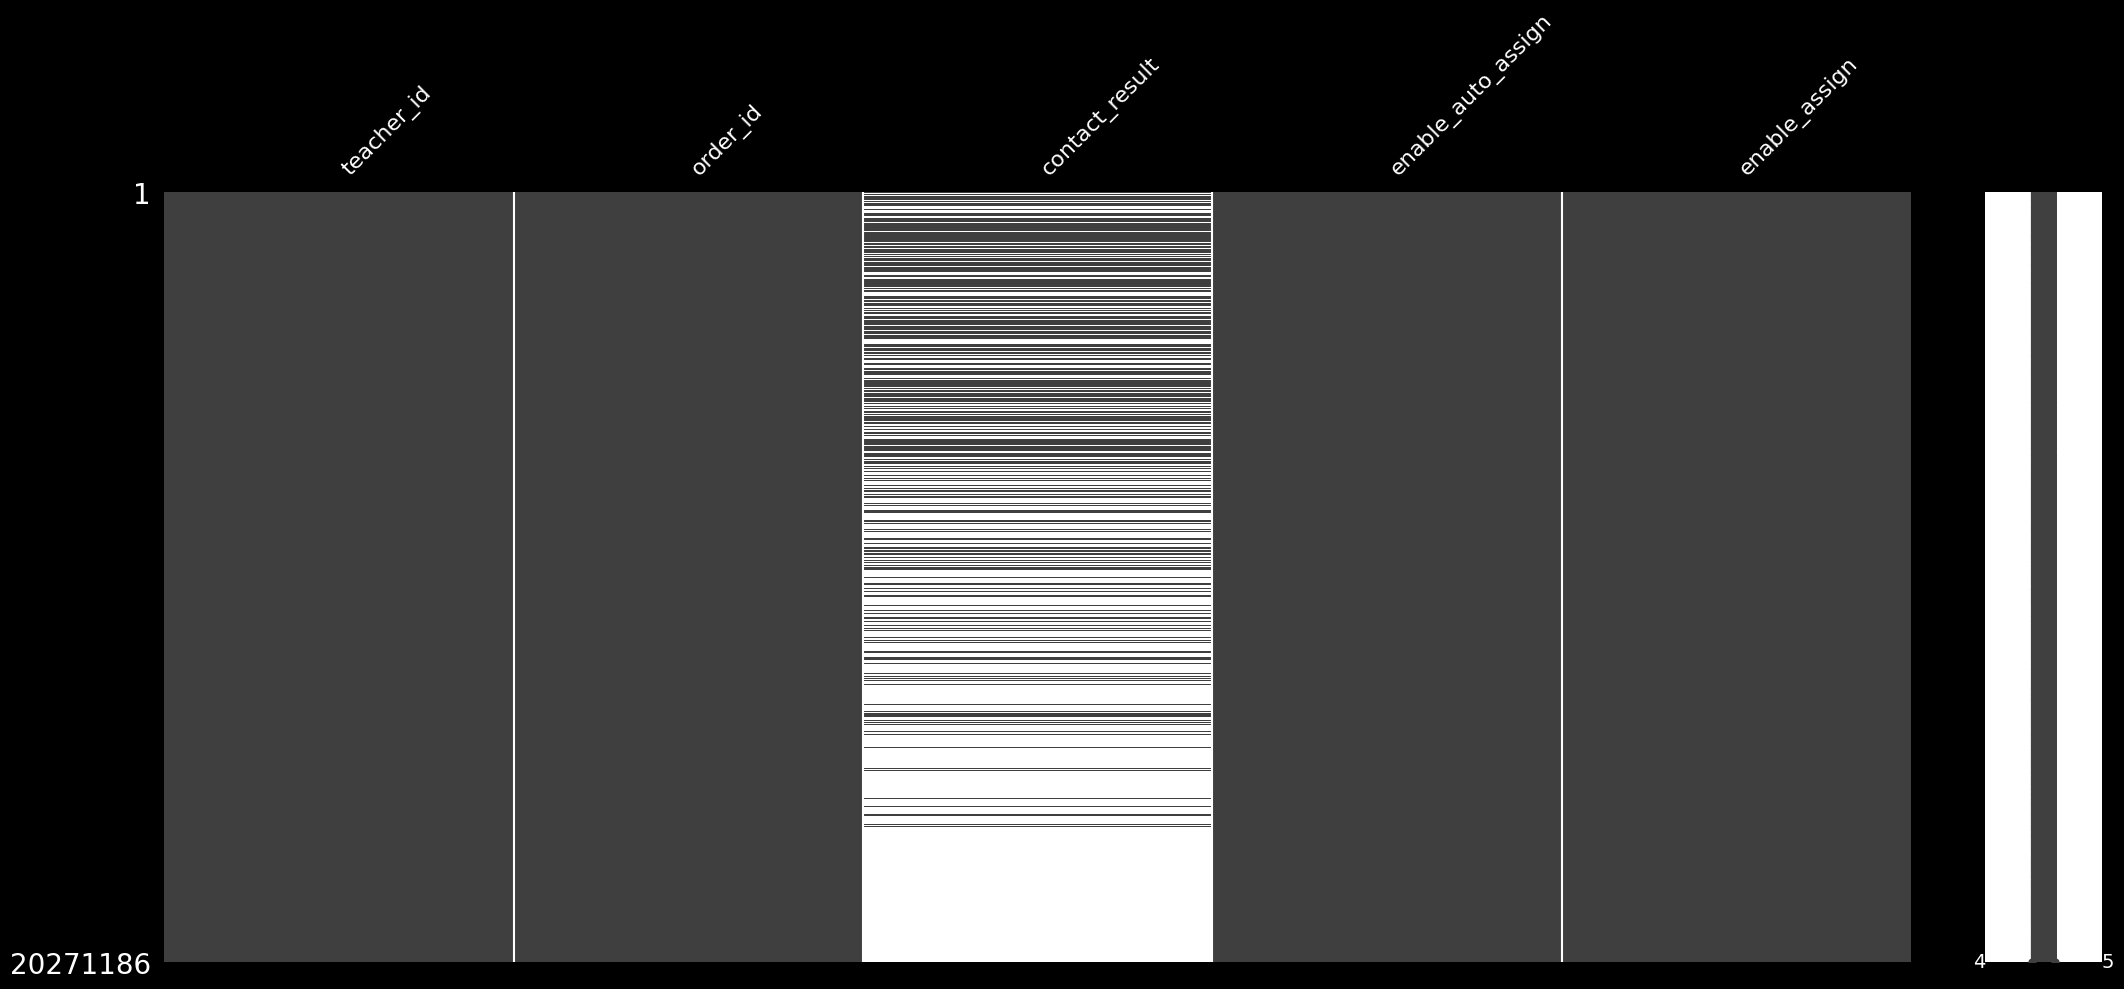

teacher_id----->0 пропусков, доля составляет 0.0


order_id----->0 пропусков, доля составляет 0.0


contact_result----->12824362 пропусков, доля составляет 0.63


enable_auto_assign----->0 пропусков, доля составляет 0.0


enable_assign----->0 пропусков, доля составляет 0.0




*********Дубликаты*********


Количество дубликатов ----> 49


In [67]:
# Создадим экземпляр класса и применим к нему функции.

suit_teach = EDA(suitable_teachers)
suit_teach.first_inf()

In [68]:
# Удалим дубликаты.

suitable_teachers.drop(suitable_teachers[suitable_teachers.duplicated()==True].index, axis=0, inplace=True)

In [69]:
# Удалим contact_result - колонка не является информативной.

suitable_teachers.drop("contact_result",axis = 1, inplace = True)

In [70]:
# Оставим только доступныхк работе репетиторов.

suitable_teachers = suitable_teachers.query('enable_auto_assign+enable_assign>=1'). reset_index()

In [71]:
# Удалим колонку индекса.

suitable_teachers.drop('index',axis = 1,inplace = True)

In [72]:
# Изменим тип данных.

suitable_teachers[['teacher_id', 'order_id', 'enable_auto_assign', 'enable_assign']] = suitable_teachers[['teacher_id', 'order_id', 'enable_auto_assign', 'enable_assign']].astype('category')

In [73]:
# Посмотрим на результат.

suitable_teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2957971 entries, 0 to 2957970
Data columns (total 4 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          category
 1   order_id            category
 2   enable_auto_assign  category
 3   enable_assign       category
dtypes: category(4)
memory usage: 54.4 MB


##Таблица данных 'orders'

                                             
                                             
                                             
    ___      __      ___   /  ___      __    
  //   ) ) //  ) ) //   ) / //___) ) //  ) ) 
 //   / / //      //   / / //       //       
((___/ / //      ((___/ / ((____   //        

**********Случайные 5 строк датафрейма**********




,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
78787,2666798,2023-07-12 14:39:10.707,2.00,Разделы: общий курс.\nКатегория ученика: взрослый.\nУровень знаний: начинающий.\nЦели: улучшить успеваемость.,1500,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 2-3. по договоренности\nОпыт репетитора: не имеет значения.\nВозраст репетитора: не имеет значения.\nПол репетитора: мужской.\nСтатус репетитора: не имеет значения.",None,NaN,16,Тестовая группа : SplitTestB,NaN,0,10,None,NaN,15.00,5,0,1,0,0,4,2,0,0,1,0,16,NaN,1169717,18.00,NaN,None,None,1
27600,1869167,2021-11-25 11:29:30.317,8.00,None,0,60,None,NaN,None,None,NaN,7,"Тестовая группа : SplitTestA\n25.11.2021 13:01 - ""Заявка прикреплена к заявке № 1869135"" (Яковлева Виктория)",NaN,0,0,None,"884,810.00",NaN,0,0,0,0,0,0,0,0,0,0,0,16,"1,869,135.00",874089,7.00,NaN,None,None,1
8017,1849583,2021-11-09 17:33:08.107,1.00,None,0,60,None,231.00,None,None,NaN,7,"Тестовая группа : SplitTestB\n09.11.2021 17:47 - ""Заявка прикреплена к заявке № 1849582"" (Назарова Ольга)",NaN,0,0,None,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,16,"1,849,582.00",867785,7.00,NaN,None,None,1
52285,1795407,2021-09-27 17:53:16.777,9.00,"+МАТЕМАТИКА\nРазделы: школьный курс.\nКатегория ученика: школьник 7 класса.\nЦель занятий: повысить успеваемость, углубленное изучение предмета.",1500,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 2. Будни вторая половина дня, выходные по договорённости. Клиент находится в Новосибирске, +4 МСК.\nОпыт репетитора: не имеет значения.\nВозраст репетитора: не имеет значения.\nПол репетитора: не имеет значения.\nСтатус репетитора: школьный преподаватель, преподаватель вуза, частный преподаватель.",2021-09-27 17:54:38.547,"88,496.00",16,None,NaN,0,10,None,"671,194.00",8.00,4,1000,3,0,0,4,0,0,0,0,0,14,"1,795,033.00",850169,13.00,NaN,4725,None,1
63060,2651071,2023-06-27 22:34:57.427,8.00,Разделы: школьный курс.\nКатегория ученика: школьник 8 класса.\nЦели: помощь по школьной программе. ОГЭ.,500,60,None,"1,235.00",Район: Калининский район.\nМесто проведения занятий: у преподавателя ().\nПредполагаемое число занятий в неделю: 2-3. По согласованию.\nОпыт репетитора: не имеет значения.\nВозраст репетитора: не имеет значения.\nПол репетитора: не имеет значения.\nСтатус репетитора: не имеет значения.,2023-06-28 13:31:26.820,"245,902.00",16,None,NaN,0,10,None,NaN,9.00,5,0,3,0,0,2,0,0,0,0,0,23,NaN,1163484,17.00,NaN,1125,None,1




**********Количество колонок и тип данных**********


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
count,"1,191,861.00",1191861,"1,181,529.00",1025351,"1,191,861.00","1,191,861.00",31,"642,447.00",1044688,705578,"705,988.00","1,191,861.00",341468,4.00,1191861,"1,191,861.00",166571,"579,698.00","1,032,470.00","1,191,861.00","1,191,861.00","1,191,861.00","1,191,861.00","1,191,861.00","1,191,861.00","1,191,861.00","1,191,861.00","1,191,861.00","1,191,861.00","1,191,861.00","1,191,861.00","582,588.00","1,191,861.00","1,042,385.00","13,518.00",747152,129665,"1,191,861.00"
unique,NaN,1190749,NaN,294447,NaN,NaN,4,NaN,609437,705033,NaN,NaN,93505,NaN,1415,NaN,818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1593,124285,NaN
top,NaN,2021-09-16 03:58:15.883,NaN,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА).\nКатегория ученика: школьник 9 класса.\nЦель занятий: подготовка к ОГЭ.,NaN,NaN,у ученика,NaN,Количество занятий в неделю: 1-2.\nВозраст репетитора: не важно.\nПол репетитора: Не важно.\n,2023-01-07 20:00:43.073,NaN,NaN,Тестовая группа : SplitTestB,NaN,0,NaN,2022-09-06 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2023-03-12 14:20:12.353,NaN
freq,NaN,4,NaN,11450,NaN,NaN,24,NaN,7234,2,NaN,NaN,72450,NaN,1038096,NaN,599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57788,37,NaN
mean,"2,340,488.45",NaN,21.39,NaN,"2,019.47",71.87,NaN,813.03,NaN,NaN,"164,486.09",24.36,NaN,"3,342,593.00",NaN,19.52,NaN,"668,223.12",22.87,14.23,212.99,13.30,12.69,12.11,14.08,11.61,19.56,28.64,0.02,0.09,28.77,"2,325,827.00","962,518.00",23.58,"1,388.37",NaN,NaN,0.96
std,"344,556.25",NaN,"6,157.33",NaN,"916,334.05","6,130.49",NaN,"8,375.08",NaN,NaN,"81,847.90","6,130.58",NaN,"185,846.59",NaN,"6,130.59",NaN,"401,302.44","6,586.82","6,130.60","11,111.45","6,130.60","6,130.60","6,130.60","6,130.60","6,130.60","6,130.60","6,131.39",0.15,0.29,"6,130.57","348,029.66","217,718.75","6,555.42","71,844.27",NaN,NaN,0.19
min,"1,742,636.00",NaN,1.00,NaN,0.00,0.00,NaN,1.00,NaN,NaN,33.00,1.00,NaN,"3,211,265.00",NaN,0.00,NaN,45.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-40.00,-110.00,0.00,0.00,0.00,263.00,1.00,1.00,0.00,NaN,NaN,0.00
25%,"2,041,441.00",NaN,3.00,NaN,500.00,60.00,NaN,228.00,NaN,NaN,"100,913.00",7.00,NaN,"3,211,265.00",NaN,10.00,NaN,"304,610.00",8.00,2.00,0.00,2.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,14.00,"2,022,765.00","868,083.00",7.00,30.00,NaN,NaN,1.00
50%,"2,341,556.00",NaN,8.00,NaN,"1,000.00",60.00,NaN,644.00,NaN,NaN,"169,516.00",16.00,NaN,"3,276,801.00",NaN,10.00,NaN,"780,665.00",10.00,3.00,0.00,2.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,16.00,"2,318,886.00","989,633.00",10.00,30.00,NaN,NaN,1.00
75%,"2,638,720.00",NaN,13.00,NaN,"1,500.00",60.00,NaN,"1,146.00",NaN,NaN,"234,330.25",16.00,NaN,"3,408,129.00",NaN,10.00,NaN,"971,565.00",12.00,4.00,0.00,3.00,1.00,0.00,4.00,0.00,20.00,40.00,0.00,0.00,23.00,"2,631,660.00","1,125,538.00",13.00,30.00,NaN,NaN,1.00




**********Обзор данных после сортировки на наличие аномалий**********




id --->
первые 5 значений [1742636 1742637 1742638 1742639 1742640]

 последние 5 значений [2936684 2936685 3211265 3342337 3605505]


order_date --->
первые 5 значений ['0029-07-18 05:28:02.684' '0042-01-12 04:26:08.039'
 '0042-01-12 05:09:05.007' '2021-09-01 00:12:16.713'
 '2021-09-01 00:16:46.867']

 последние 5 значений ['2023-11-05 23:58:07.547' '2023-11-05 23:58:26.597'
 '2023-11-05 23:58:31.963' '2023-11-05 23:59:09.900'
 '2023-11-05 23:59:45.687']


subject_id --->
первые 5 значений [1. 2. 3. 4. 5.]

 последние 5 значений [3.600000e+01 3.211265e+06 3.342337e+06 3.605505e+06          nan]


purpose --->
первые 5 значений ['\n\n\u200bКатегория ученика : Взрослый\u200a'
 '\n\n\u200bКатегория ученика : Взрослый\u200a\n\u200bРазделы : инвестиции\u200a'
 '\n\n\u200bКатегория ученика : школьники 6 класса\u200a'
 '\n\n\u200bКатегория ученика : школьники 9 класса\u200a'
 '\nМесто проведения занятий: у ученика (у

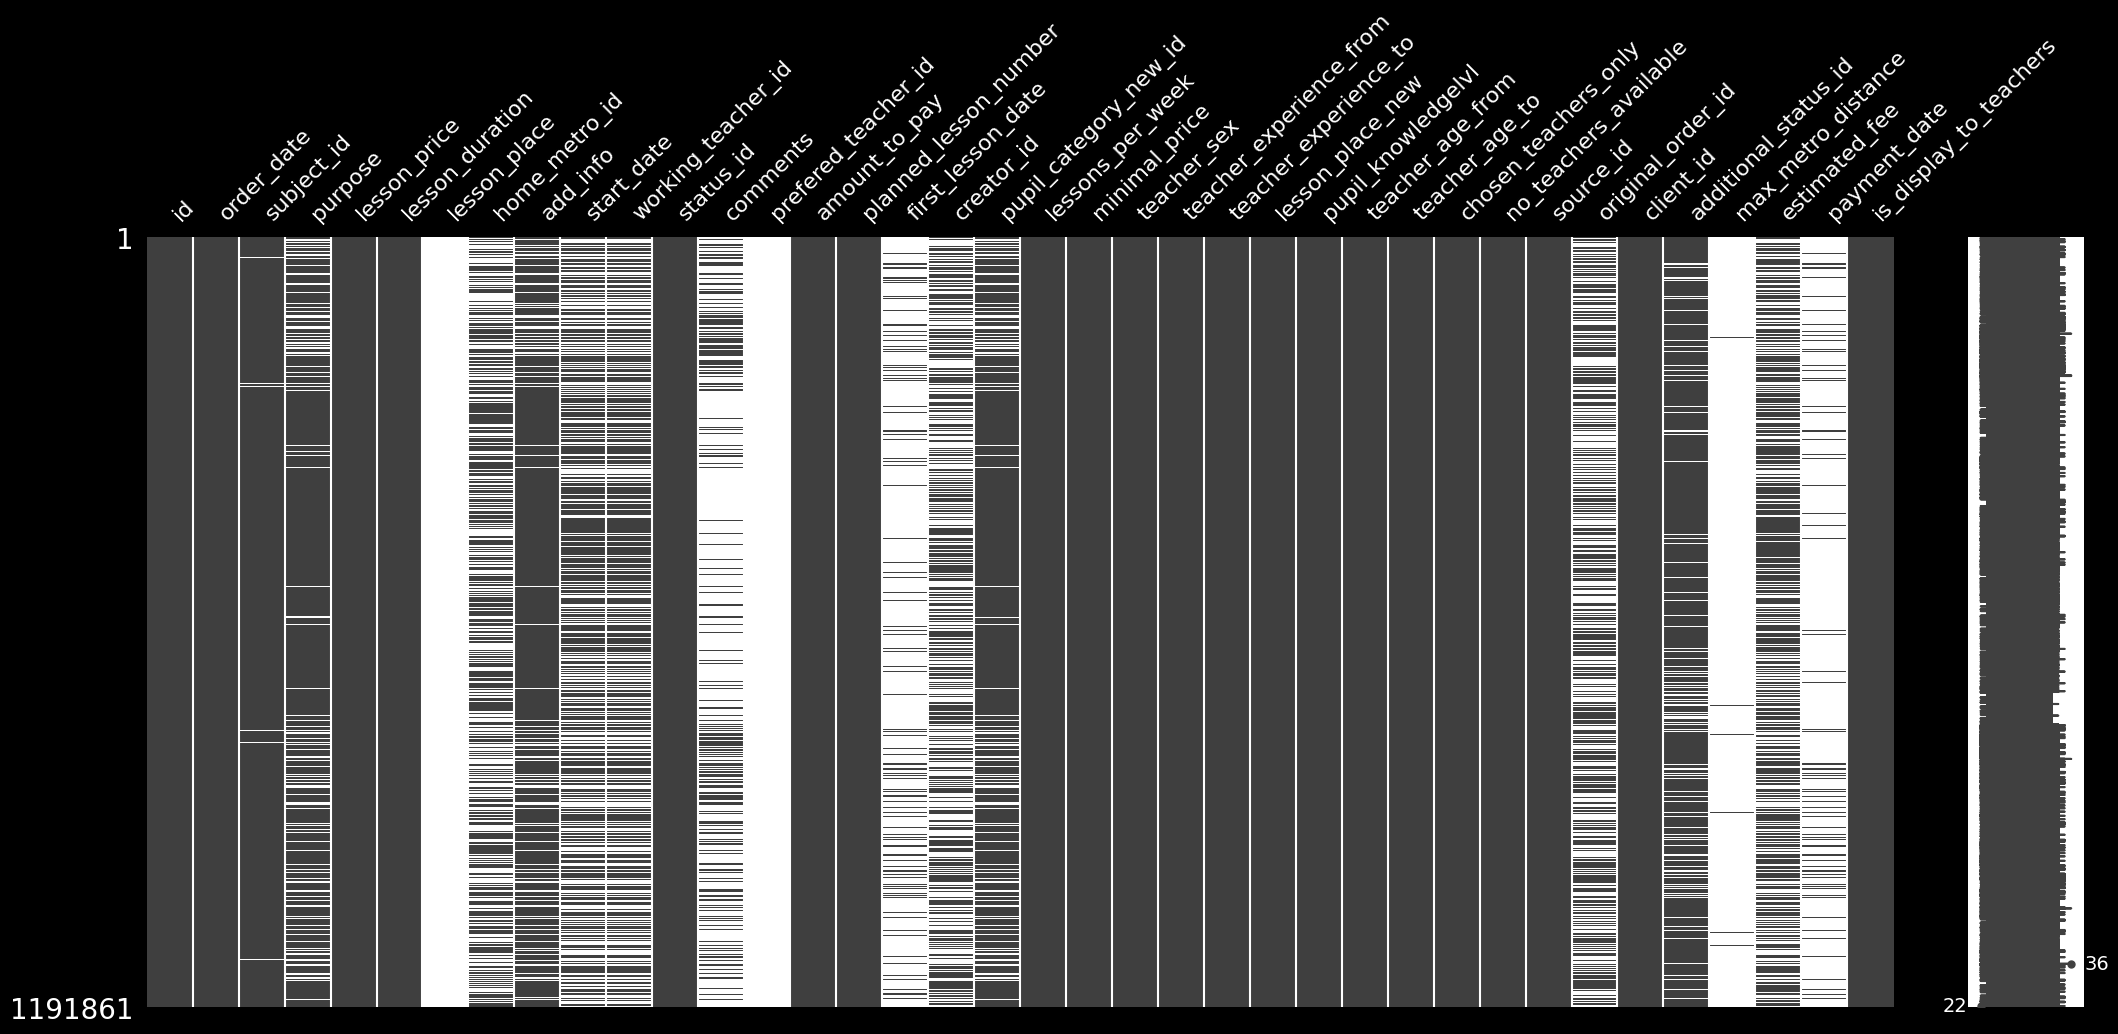

id----->0 пропусков, доля составляет 0.0


order_date----->0 пропусков, доля составляет 0.0


subject_id----->10332 пропусков, доля составляет 0.01


purpose----->166510 пропусков, доля составляет 0.14


lesson_price----->0 пропусков, доля составляет 0.0


lesson_duration----->0 пропусков, доля составляет 0.0


lesson_place----->1191830 пропусков, доля составляет 1.0


home_metro_id----->549414 пропусков, доля составляет 0.46


add_info----->147173 пропусков, доля составляет 0.12


start_date----->486283 пропусков, доля составляет 0.41


working_teacher_id----->485873 пропусков, доля составляет 0.41


status_id----->0 пропусков, доля составляет 0.0


comments----->850393 пропусков, доля составляет 0.71


prefered_teacher_id----->1191857 пропусков, доля составляет 1.0


amount_to_pay----->0 пропусков, доля составляет 0.0


planned_lesson_number----->0 пропусков, доля составляет 0.0


first_lesson_date----->1025290 пропусков, доля составляет 0.86


creator_id----->612163 пропусков, доля 

In [75]:
# Создадим экземпляр класса и применим к нему функции.

order = EDA(orders)
order.first_inf()

In [77]:
# удалим дубликаты

orders.drop_duplicates(inplace = True)

In [79]:
# посмотрим на количество пропусков.

orders.isna(). sum()

id                               0
order_date                       0
subject_id                   10325
purpose                     166423
lesson_price                     0
lesson_duration                  0
lesson_place               1190930
home_metro_id               548952
add_info                    147099
start_date                  485860
working_teacher_id          485450
status_id                        0
comments                    849661
prefered_teacher_id        1190958
amount_to_pay                    0
planned_lesson_number            0
first_lesson_date          1024519
creator_id                  611633
pupil_category_new_id       159306
lessons_per_week                 0
minimal_price                    0
teacher_sex                      0
teacher_experience_from          0
teacher_experience_to            0
lesson_place_new                 0
pupil_knowledgelvl               0
teacher_age_from                 0
teacher_age_to                   0
chosen_teachers_only

In [80]:
# Удалим неинформативные колонки или колонки создающие утечку данных.

orders.drop(['start_date','comments', 'estimated_fee','first_lesson_date','lesson_place',
             'working_teacher_id','additional_status_id','prefered_teacher_id',
             'payment_date','amount_to_pay','client_id','lesson_price',
             'purpose','creator_id','max_metro_distance','order_date'],axis=1,inplace=True)

In [81]:
# Посмотрим на значения повторяющиеся везде.

orders.query('planned_lesson_number in [3211265,3342337,3605505]')

,id,subject_id,lesson_duration,home_metro_id,add_info,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,is_display_to_teachers
105390,3211265,"3,211,265.00",3211265,"3,211,265.00",None,3211265,3211265,"3,211,265.00",3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,1,1,3211265,"3,211,265.00",1
109392,3342337,"3,342,337.00",3342337,"3,342,337.00",None,3342337,3342337,"3,342,337.00",3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,1,1,3342337,"3,342,337.00",1
437216,3605505,"3,605,505.00",3605505,"3,605,505.00",None,3605505,3605505,"3,605,505.00",3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,1,1,3605505,"3,605,505.00",1


In [82]:
# Удалим явно лишние значения дублирующиеся во всех колонках.

orders. drop(orders.query('planned_lesson_number in [3211265,3342337,3605505]'). index, axis=0, inplace=True)

In [83]:
# Исправим индекс датафрейма после удаления строк.

orders = orders.reset_index(drop=True)

**status_id**

In [84]:
# Закодируем значения для будущего target.

orders.loc[orders['status_id'].isin([1,2,3,4,7,8,9,10,11,12,14,16]),'status_id'] = 0

In [85]:
# Закодируем значения для будущего target.

orders.loc[orders['status_id'].isin([5,6,13,15]),'status_id'] = 1

In [86]:
# Посмотрим на результат.

orders.status_id.value_counts(dropna=False).to_frame().sort_index()

,status_id
0,1063669
1,127284


**home_metro_id**

In [87]:
# Посмотрим на количество повторяющихся значений.

orders.query('home_metro_id.notna()')['home_metro_id'].value_counts(). to_frame()

,home_metro_id
228.00,4294
459.00,4234
231.00,4172
316.00,4093
197.00,3821
...,...
"2,648.00",1
679.00,1
"1,912.00",1
"2,182.00",1


In [88]:
# Посмотрим на список значений.

set(orders.home_metro_id.values)

{nan,
 1.0,
 nan,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 nan,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 nan,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,


In [89]:
# Заполним пропуски.

orders.home_metro_id.fillna(-666, inplace=True)
FLAG['orders'] = {'-666':['home_metro_id']}

**pupil_category_new_id**

In [90]:
#

orders.pupil_category_new_id.value_counts(dropna=False).to_frame()

,pupil_category_new_id
10.00,171374
NaN,159305
12.00,140853
15.00,113745
14.00,97127
11.00,90060
9.00,85297
8.00,71155
7.00,55446
6.00,47290


In [91]:
# Заполним пустые значения.

orders.pupil_category_new_id.fillna(13.00, inplace=True)

In [92]:
# Обновим словарь с заглушками.

FLAG['orders'] = {'-666':['home_metro_id'],'13.00':['pupil_category_new_id']}

**original_order_id**

In [93]:
# Заполним колонку с original_order_id без значений значением 'id' - оригинальная колонка является сама себе оригиналом.

orders.loc[orders['original_order_id'].isna(),'original_order_id'] = orders.loc[orders['original_order_id'].isna(),'id']

In [94]:
# Изменим тип данных на категорию.

orders['original_order_id'] = orders['original_order_id'].astype('int')
orders['original_order_id'] = orders['original_order_id'].astype('category')

**status_id**

In [95]:
# Создадим новую колонку для обозначения оплаченных заявок сгрупированных по original_order_id.

status_group =orders.groupby('original_order_id')['status_id'].sum().to_frame().reset_index()
status_group = status_group.rename(columns={"status_id": "status_id_new"})
print(orders.groupby('original_order_id')['status_id'].sum().values.sum())
status_group.status_id_new.value_counts()

127284


0    510622
1    123226
2      1930
3        58
4         6
Name: status_id_new, dtype: int64

In [96]:
# Возьмем случайную заявку для проверки.

orders.query('original_order_id==263.00')['status_id']

448915    0
449482    1
Name: status_id, dtype: int32

In [97]:
# Соединими датафреймы.

orders = orders.merge(status_group, on='original_order_id',how="left")

In [98]:
# Проверим значения новой колонки.

orders.query('original_order_id==263.00')['status_id_new']

448915    1
449482    1
Name: status_id_new, dtype: int32

In [99]:
# Посмотрим на дублирующиеся значений просуммированных статусов.

orders.status_id_new.value_counts(dropna=False).to_frame().sort_index()

,status_id_new
0,905201
1,277754
2,7558
3,379
4,61


In [100]:
# Заменим значения 2,3,4 на 1.

orders.loc[orders['status_id_new'].isin([2,3,4]),'status_id_new'] = 1

In [101]:
# Проверим результат.

orders.status_id_new.value_counts(dropna=False).to_frame().sort_index()

,status_id_new
0,905201
1,285752


**subject_id**

In [102]:
# Посмотрим на количество значений колонки.

orders.subject_id.value_counts(dropna=False).to_frame().sort_index()

,subject_id
1.00,109051
2.00,170675
3.00,17515
4.00,12594
5.00,4456
6.00,8682
7.00,16147
8.00,311066
9.00,58706
10.00,57223


In [103]:
# Ещё раз взглянем на количество пропусков.

orders.query('subject_id.isna()').shape[0]

10325

In [104]:
# Создадим словарь для сбора информации о предмете из колонки add_info.

dict_for_subject = {1:['русск'],2:['англ'],3:['немец'],4:['франц'],5:['итал'],6:['испан'],7:['китай'],8:['матем', 'математик',' математ', 'алгеб','геометр'],9:['физик'],10:['информат','программир','информатик'],11:['хими']
,12:['биолог'],13:['истор'],14:['обществозн','правовед'],15:['литер'],16:['георграф'],17:['эконом'],18:['начальн','подготовка к школе'],19:['музык'],
20:['логопед'],25:['японск'],27:['изобр','рисов'],29:['дошкольн'],36:['спорт','фитнес']}

In [105]:
# Соберем в словарь информацию о предмете и индексе.

wer= {}
filter_sub = orders.query('subject_id.isna()')

for m in list(dict_for_subject.values()):
  for k in m:
    key_dict_subject=[p for p in dict_for_subject if k in dict_for_subject[p]][0]
    wer[key_dict_subject] = filter_sub[filter_sub['add_info'].str.lower().str.contains(k, regex=True,na=False)].index.to_list()

In [106]:
# Заполним пустые значения при помощи полученного словаря с номеров предмета и индексами.

for t in wer.values():
  orders.loc[t,'subject_id']=[p for p in wer if wer[p]==t][0]

In [107]:
#

orders.query('subject_id.isna()').shape

(8930, 23)

In [108]:
#

language = orders.query('subject_id.isna()')[orders.query('subject_id.isna()')['add_info'].str.lower().str.contains('язык', regex=True,na=False)].index.to_list()
print (len(language))
orders.loc[language,'subject_id']=33

184


In [109]:
#

math = orders.query('subject_id.isna()')[orders.query('subject_id.isna()')['add_info'].str.lower().str.contains('матем', regex=True,na=False)].index.to_list()
print (len(math))
orders.loc[math,'subject_id']=8

465


In [110]:
#

others = orders.query('subject_id.isna()')[orders.query('subject_id.isna()')['add_info'].str.lower().str.contains('прочее|пожелания:|понравился', regex=True,na=False)].index.to_list()
print (len(others))
orders.loc[others,'subject_id']=21

842


In [111]:
#

orders.query('subject_id.isna()').shape

(7439, 23)

In [112]:
#

orders.query('subject_id.isna()')['add_info'].value_counts()

Количество занятий в неделю: пока не знаю.\nОпыт репетитора: не важно.\nВозраст репетитора: не важно.\nСтатус репетитора: не имеет значения.\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           41
Изучать механику 1 курса инженерного факультета (включает динамику ,  статику ..) ; электрот

In [113]:
# Заполним оставшиеся значения

orders.subject_id.fillna(21, inplace=True)

In [114]:
# Удалим add_info - т.к. вся необхлдимая информация уже взята.

orders.drop('add_info',axis = 1, inplace = True)

In [115]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190953 entries, 0 to 1190952
Data columns (total 22 columns):
 #   Column                   Non-Null Count    Dtype   
---  ------                   --------------    -----   
 0   id                       1190953 non-null  int32   
 1   subject_id               1190953 non-null  float32 
 2   lesson_duration          1190953 non-null  int32   
 3   home_metro_id            1190953 non-null  float32 
 4   status_id                1190953 non-null  int32   
 5   planned_lesson_number    1190953 non-null  int32   
 6   pupil_category_new_id    1190953 non-null  float32 
 7   lessons_per_week         1190953 non-null  int32   
 8   minimal_price            1190953 non-null  int32   
 9   teacher_sex              1190953 non-null  int32   
 10  teacher_experience_from  1190953 non-null  int32   
 11  teacher_experience_to    1190953 non-null  int32   
 12  lesson_place_new         1190953 non-null  int32   
 13  pupil_knowledgelvl       11

In [116]:
# Соберем в список колонки содержащие в названии id.

id_order = []

for m in orders.select_dtypes(exclude = 'category').columns.to_list():
  if "id" in m:
    id_order.append(m)
    print(f'**********{m}**********')
    print (orders[m].value_counts(normalize = True))
    print (orders[m].isna().sum())
    print (f'{orders[m].duplicated().sum()}\n\n\n')

**********id**********
2294054   0.00
1881823   0.00
1881803   0.00
1881802   0.00
1881801   0.00
          ... 
2470529   0.00
2470528   0.00
2470527   0.00
2470526   0.00
2280506   0.00
Name: id, Length: 1190953, dtype: float64
0
0



**********subject_id**********
8.00    0.26
2.00    0.14
1.00    0.09
18.00   0.05
11.00   0.05
9.00    0.05
10.00   0.05
19.00   0.04
12.00   0.04
14.00   0.03
33.00   0.03
21.00   0.03
13.00   0.02
3.00    0.01
20.00   0.01
7.00    0.01
29.00   0.01
4.00    0.01
27.00   0.01
15.00   0.01
6.00    0.01
16.00   0.01
17.00   0.01
23.00   0.01
36.00   0.00
25.00   0.00
5.00    0.00
Name: subject_id, dtype: float64
0
1190926



**********home_metro_id**********
-666.00    0.46
228.00     0.00
459.00     0.00
231.00     0.00
316.00     0.00
           ... 
2,648.00   0.00
679.00     0.00
1,912.00   0.00
2,182.00   0.00
1,348.00   0.00
Name: home_metro_id, Length: 2324, dtype: float64
0
1188629



**********status_id**********
0   0.89
1   0.11
Name: status_i

In [117]:
# Изменим тип данных на категорию.

orders[id_order] = orders[id_order].astype('category')

In [118]:
# Удалим старую колонку status_id.

orders.drop('status_id',axis =1 ,inplace = True)

In [119]:
# Создадим список колонок, содержащих менее 5 уникальных значений.

list_not_cat  = []


for m in orders.select_dtypes(exclude = 'category').columns.to_list():
  if orders[m].nunique() < 5:
    list_not_cat.append(m)
    print(f'**********{m}**********')
    print (orders[m].value_counts(normalize = True))
    print (orders[m].isna().sum())
    print (f'{orders[m].duplicated().sum()}\n\n\n')

**********teacher_sex**********
3   0.46
2   0.33
0   0.17
1   0.04
Name: teacher_sex, dtype: float64
0
1190949



**********chosen_teachers_only**********
0   0.98
1   0.02
Name: chosen_teachers_only, dtype: float64
0
1190951



**********no_teachers_available**********
0   0.91
1   0.09
Name: no_teachers_available, dtype: float64
0
1190951



**********is_display_to_teachers**********
1   0.96
0   0.04
Name: is_display_to_teachers, dtype: float64
0
1190951





In [120]:
# Изменим тип этих колонок.

orders[list_not_cat] = orders[list_not_cat].astype('category')

In [121]:
# Удалим неинформативные колонки.

orders.drop(['teacher_age_to', 'teacher_experience_to', 'minimal_price'], axis = 1 , inplace = True)

In [122]:
# Создадим список колонок, содержащих менее 5 уникальных значений.

others  = []


for m in orders.select_dtypes(exclude = 'category').columns.to_list():
  if orders[m].nunique() >= 5:
    others.append(m)
    print(f'**********{m}**********')
    print (orders[m].value_counts())
    print (orders[m].isna().sum())
    print (f'{orders[m].duplicated().sum()}\n\n\n')

**********lesson_duration**********
60     1135630
90       25634
45       19901
120       7210
0         2386
135        192
Name: lesson_duration, dtype: int64
0
1190947



**********planned_lesson_number**********
10    937982
0     166468
7      68302
2      11622
1       6579
Name: planned_lesson_number, dtype: int64
0
1190948



**********lessons_per_week**********
3    433600
4    236320
0    175122
5    156357
2    142393
6     28205
7     15086
1      3870
Name: lessons_per_week, dtype: int64
0
1190945



**********teacher_experience_from**********
0     844801
5     183588
1      61272
10     60759
2      13686
3      13053
4       5336
7       5037
6       1155
8        883
15       673
20       368
9         64
30        63
25        54
12        33
11        26
13        15
24        11
23         9
22         8
18         7
14         6
28         5
19         4
26         4
35         4
27         4
51         3
32         3
16         3
21         3
40         3
50     

In [123]:
# Изменим тип данных.

orders[['pupil_knowledgelvl', 'lesson_place_new']] = orders[['pupil_knowledgelvl', 'lesson_place_new']].astype('category')

In [124]:
# Обновим список и изменим оставшиеся колонки по типу данных.

others  = [k for k in others if k not in ['pupil_knowledgelvl', 'lesson_place_new']]
orders[others] = orders[others].convert_dtypes()

In [125]:
# Посмотрим на результат.

orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190953 entries, 0 to 1190952
Data columns (total 18 columns):
 #   Column                   Non-Null Count    Dtype   
---  ------                   --------------    -----   
 0   id                       1190953 non-null  category
 1   subject_id               1190953 non-null  category
 2   lesson_duration          1190953 non-null  Int32   
 3   home_metro_id            1190953 non-null  category
 4   planned_lesson_number    1190953 non-null  Int32   
 5   pupil_category_new_id    1190953 non-null  category
 6   lessons_per_week         1190953 non-null  Int32   
 7   teacher_sex              1190953 non-null  category
 8   teacher_experience_from  1190953 non-null  Int32   
 9   lesson_place_new         1190953 non-null  category
 10  pupil_knowledgelvl       1190953 non-null  category
 11  teacher_age_from         1190953 non-null  Int32   
 12  chosen_teachers_only     1190953 non-null  category
 13  no_teachers_available    11

##Таблица данных 'prefered_teachers_order_id'

                                                                               
                                                                               
                              //  ) )                                          
    ___      __      ___   __//__            __  ___  ___      ___      ___    
  //   ) ) //  ) ) //___) ) //                / /   //___) ) //   ) ) //   ) ) 
 //___/ / //      //       //                / /   //       //   / / //        
//       //      ((____   //          _____ / /   ((____   ((___( ( ((____     
           
           
           
   / __    
  //   ) ) 
 //   / /  
//   / /   

**********Случайные 5 строк датафрейма**********




,order_id,teacher_id
77365,2351348,13408
171987,2076936,57045
279377,1888721,86802
26174,2878782,20898
988724,2690207,193761




**********Количество колонок и тип данных**********


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135198 entries, 0 to 1135197
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   order_id    1135198 non-null  int32
 1   teacher_id  1135198 non-null  int32
dtypes: int32(2)
memory usage: 8.7 MB
None


**********Описание датафрейма**********




,order_id,teacher_id
count,"1,135,198.00","1,135,198.00"
mean,"2,267,042.88","143,598.53"
std,"331,442.68","73,975.35"
min,"1,742,638.00",33.00
25%,"1,984,395.00","86,423.00"
50%,"2,246,181.00","144,398.00"
75%,"2,511,700.00","204,321.00"
max,"2,946,594.00","312,232.00"




**********Обзор данных после сортировки на наличие аномалий**********




order_id --->
первые 5 значений [1742638 1742639 1742640 1742641 1742642]

 последние 5 значений [2946580 2946585 2946587 2946593 2946594]


teacher_id --->
первые 5 значений [33 51 52 86 87]

 последние 5 значений [312015 312065 312193 312215 312232]


**********Пропуски**********


Матрица пропусков данных


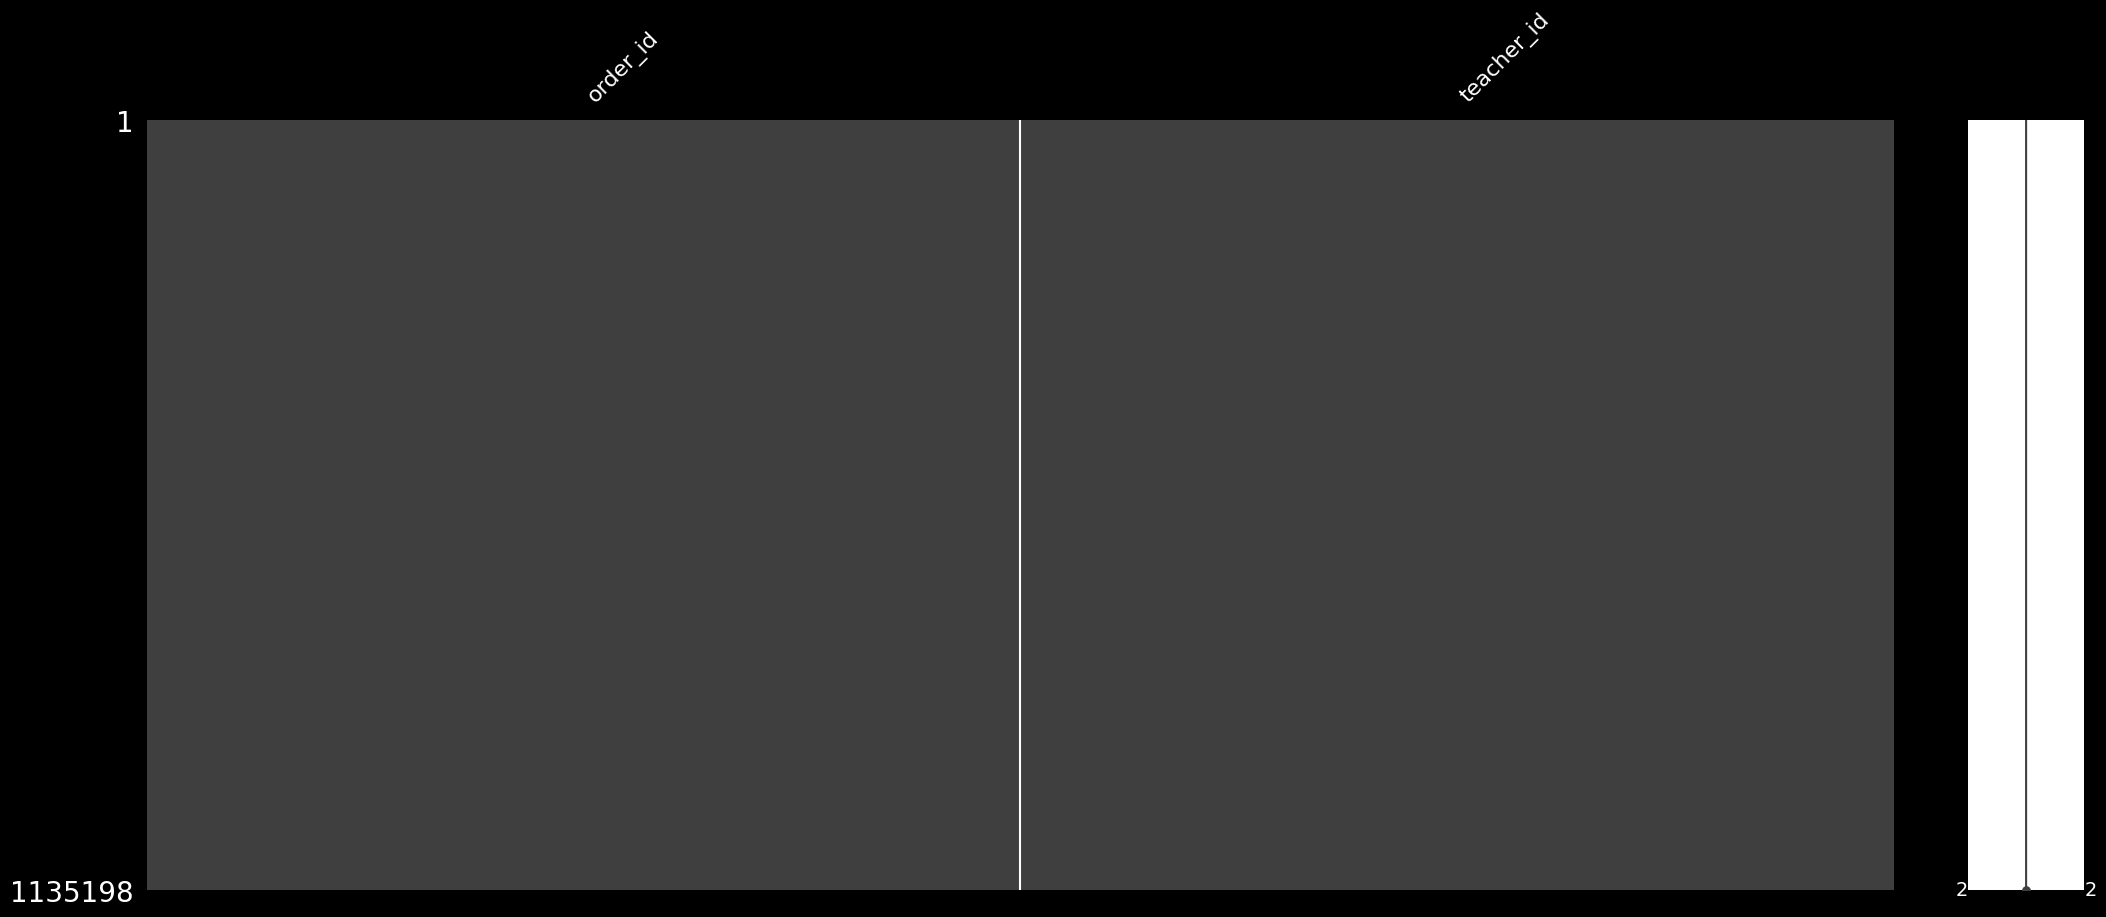



Пропуски не обнаружены




*********Дубликаты*********


Количество дубликатов ----> 16


In [126]:
# Создадим экземпляр класса и применим к нему функции.

pref = EDA(prefered_teachers_order_id)
pref.first_inf()

In [127]:
# Удалим дубликаты.

prefered_teachers_order_id.drop(prefered_teachers_order_id.duplicated().index.to_list(), axis = 0 , inplace = True)

In [128]:
# Изменим тип данных.

prefered_teachers_order_id[['order_id','teacher_id']] = prefered_teachers_order_id[['order_id','teacher_id']].astype('category')

##Вывод

Итак было загружено и рассмотрено 4 датафрейма, предоставленные клиентом:

**teachers_info:**

- Размерность составляет 307972 строки на 80 столбцов;

- Обнаружены и удалены большое количество задублированных колонок имеющих идентичное содержание с остальными колонками. Удалены колонки, содержащие большое количество пропусков 'status_relevant_date','pupil_needed_date','free_time_relevance_date'. Удалены колонки, из которых либо сделана выжимка, либо как малоинформативные: 'partner_id','remote_comments','information','external_comments','comments','is_email_confirmed','is_cell_phone_confirmed','is_pupils_needed','amount_to_pay','is_individual','status_school_id', 'status_college_id','passport_id','status_institution_id'.

- Колонки с датами переведены в числовые, а именно учтена разница между датами и последней актуальной датой в датафрейме - 11/07/23.

- Колонка "photo_path" переведена в закодированный вид с учетом содержания реальной ссылки на файл с фото.

- Из колонки "information" взята информация, какие заявки на регистрацию не были учтены и удалены эти строки в количестве - 7 109 строк. Так же из колонки "comments" взята информация о задублированных заявках и удалены строки в количестве 8895 строк.

- В колонке "sex" значения 0 и 3 заменены на наиболее частое значение пола - 2.

Все данные в колонках  приведены к наиболее удобному для анализа типу.




**suitable_teachers:**

- Размерность датафрейма составляет 20271186 строк на 5 столбцов;

- Удалены 49 дубликатов;

- Удален столбец contact_result - как малоинформативный;

Все данные в колонках  приведены к наиболее удобному для анализа типу.


**orders:**

- Размерность составляет 1191861 строки на 38 столбцов;

- Удалены 900 дубликатов строк;

- Удалены колонки 'start_date','comments', 'estimated_fee','first_lesson_date','lesson_place','working_teacher_id','additional_status_id','prefered_teacher_id','payment_date','amount_to_pay','client_id','lesson_price',
'purpose','creator_id','max_metro_distance','order_date','add_info','teacher_age_to', 'teacher_experience_to', 'minimal_price';

- Колонка status_id - целевой признак закодирована по факту оплаты, так же статус оплаты перенесён с учетом группироки по original_order_id. Новое название колонки стало status_id_new. Старая колонка status_id - удалена.

- В колонке 'home_metro_id' - пропуски заполнены заглушкой "-666".

- В колонке "pupil_category_new_id" - пропуски заполнены заглушкой "13".

- Пустые значения в колонке "'original_order_id" заполнены значением заявки из "id".

- Для заполнения пропусков в "subject_id" взята информация из 'add_info' по частичному совпадению названия предметов. Таким образом удалось заполнить 2 886 пропусков из 10 325. Оставшиеся пропуски заполнены значением категории предмета - 21 ("Другой")

**prefered_teachers_order_id:**

- Размерность датафрейма составляет 1135198 строк на 2 столбца;

- Удалины 16 дубликатов строк;

- Аномалии, пропуски -  не обнаружены;

- Данный датафрейм не будет использоваться для поставленной цели клиента, т.к. на момент подачи заявки на репетитора такой информации нет.

Всё данные в датафреймах проведены к необходимому типу, что позволяет в дальнейшем провести более глубокий анализ после объединения датафреймов. Большое количество категориальных данных говорит о необходимости проведения кодировки для обучения модели. Размеры датафреймов отличаются по количеству строк, на следующем шаге будет решаться проблема пропусков в данных. Цель проекта - задача классификации по возможной оплате заказа.

#**Предобработка данных**

##Объединение датафреймов

In [129]:
# Для начала объединим датафреймы suitable_teachers, teachers_info.

df_suit= pd.merge(
    suitable_teachers, teachers_info,
    left_on='teacher_id',
    right_on='id',
    how='inner')

In [130]:
# Проверим на наличие дубликатов, пропусков.

print (f'Количество дубликатов: {df_suit.duplicated().sum()}\n\n')
display (df_suit.isna(). sum())
df_suit.info()

Количество дубликатов: 0




teacher_id                    0
order_id                      0
enable_auto_assign            0
enable_assign                 0
id                            0
user_id                       0
is_home_lessons               0
is_external_lessons           0
lesson_duration               0
lesson_cost                   0
status_id                     0
status_display                0
russian_level_id              0
home_country_id               0
is_confirmed                  0
photo_path                    0
is_display                    0
rating_id                     0
rating                        0
effective_rating              0
area_id                       0
sex                           0
is_remote_lessons             0
show_on_map                   0
send_mailing                  0
send_suitable_orders          0
rating_for_users              0
rating_for_admin              0
is_edited                     0
orders_allowed                0
display_days                  0
verifica

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2952648 entries, 0 to 2952647
Data columns (total 42 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   teacher_id                  int64   
 1   order_id                    category
 2   enable_auto_assign          category
 3   enable_assign               category
 4   id                          category
 5   user_id                     category
 6   is_home_lessons             category
 7   is_external_lessons         category
 8   lesson_duration             Int16   
 9   lesson_cost                 Int32   
 10  status_id                   category
 11  status_display              category
 12  russian_level_id            category
 13  home_country_id             category
 14  is_confirmed                category
 15  photo_path                  category
 16  is_display                  category
 17  rating_id                   category
 18  rating                      Int32   
 19  

In [131]:
# Затем получившийся ранее результат объединим с orders.

df = pd.merge(
    df_suit, orders,
    left_on='order_id',
    right_on='id',
    how='right')

In [132]:
# Проверим на наличие дубликатов, пропусков.

print (f'Количество дубликатов: {df.duplicated().sum()}\n\n')
display (df.isna(). sum())
df.info()

Количество дубликатов: 0




teacher_id                    509611
order_id                      509611
enable_auto_assign            509611
enable_assign                 509611
id_x                          509611
user_id                       509611
is_home_lessons               509611
is_external_lessons           509611
lesson_duration_x             509611
lesson_cost                   509611
status_id                     509611
status_display                509611
russian_level_id              509611
home_country_id               509611
is_confirmed                  509611
photo_path                    509611
is_display                    509611
rating_id                     509611
rating                        509611
effective_rating              509611
area_id                       509611
sex                           509611
is_remote_lessons             509611
show_on_map                   509611
send_mailing                  509611
send_suitable_orders          509611
rating_for_users              509611
r

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3441918 entries, 0 to 3441917
Data columns (total 60 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   teacher_id                  float64 
 1   order_id                    float64 
 2   enable_auto_assign          category
 3   enable_assign               category
 4   id_x                        category
 5   user_id                     category
 6   is_home_lessons             category
 7   is_external_lessons         category
 8   lesson_duration_x           Int16   
 9   lesson_cost                 Int32   
 10  status_id                   category
 11  status_display              category
 12  russian_level_id            category
 13  home_country_id             category
 14  is_confirmed                category
 15  photo_path                  category
 16  is_display                  category
 17  rating_id                   category
 18  rating                      Int32   
 19  

##Работа с дубликатами, аномалиями, пропусками после объединения в единый датафрейм.

In [133]:
# удалим дубликаты

df.drop_duplicates(inplace = True)

In [134]:
# Перепроверим оставшееся количество пропусков.

print(f' Количество пропусков: \n\n{df.isna(). sum()}')
print ('\n\n')
df.query('last_visited_numb.isna()'). shape

 Количество пропусков: 

teacher_id                    509611
order_id                      509611
enable_auto_assign            509611
enable_assign                 509611
id_x                          509611
user_id                       509611
is_home_lessons               509611
is_external_lessons           509611
lesson_duration_x             509611
lesson_cost                   509611
status_id                     509611
status_display                509611
russian_level_id              509611
home_country_id               509611
is_confirmed                  509611
photo_path                    509611
is_display                    509611
rating_id                     509611
rating                        509611
effective_rating              509611
area_id                       509611
sex                           509611
is_remote_lessons             509611
show_on_map                   509611
send_mailing                  509611
send_suitable_orders          509611
rating_for_us

(509611, 60)

In [135]:
# Удалим строки с пропусками.

df.drop(df.query('last_visited_numb.isna()').index.to_list(),axis = 0 , inplace = True)

In [136]:
# Восстановим индексы по умолчанию.

df = df.reset_index(drop=True)

In [137]:
# Изменим тип данных на категорию - teacher_id,order_id.


df[['teacher_id','order_id']] = df[['teacher_id','order_id']].astype('int').astype('category')

In [165]:
# Сохраним получившийся датасет

df.to_feather('df_final.feather')

In [139]:
#df=pd.read_feather('/content/Repetit_project/df_final.feather')

In [140]:
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2932307 entries, 0 to 2932306
Data columns (total 60 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   teacher_id                  category
 1   order_id                    category
 2   enable_auto_assign          category
 3   enable_assign               category
 4   id_x                        category
 5   user_id                     category
 6   is_home_lessons             category
 7   is_external_lessons         category
 8   lesson_duration_x           Int16   
 9   lesson_cost                 Int32   
 10  status_id                   category
 11  status_display              category
 12  russian_level_id            category
 13  home_country_id             category
 14  is_confirmed                category
 15  photo_path                  category
 16  is_display                  category
 17  rating_id                   category
 18  rating                      Int32   
 19  

#Работа с признаками

##EDA (типичный портрет пользователя,исследование баланса, динамика).

In [141]:
# Проверим идентичность данных.

(df['id_x'].astype('int') - df['teacher_id'].astype('int')). value_counts ()

0    2932307
dtype: int64

In [142]:
# Удалим дублирующуюся конкурс id_x из датафрейма df_suit, т. к. .

df. drop(['id_x'], axis=1, inplace= True)

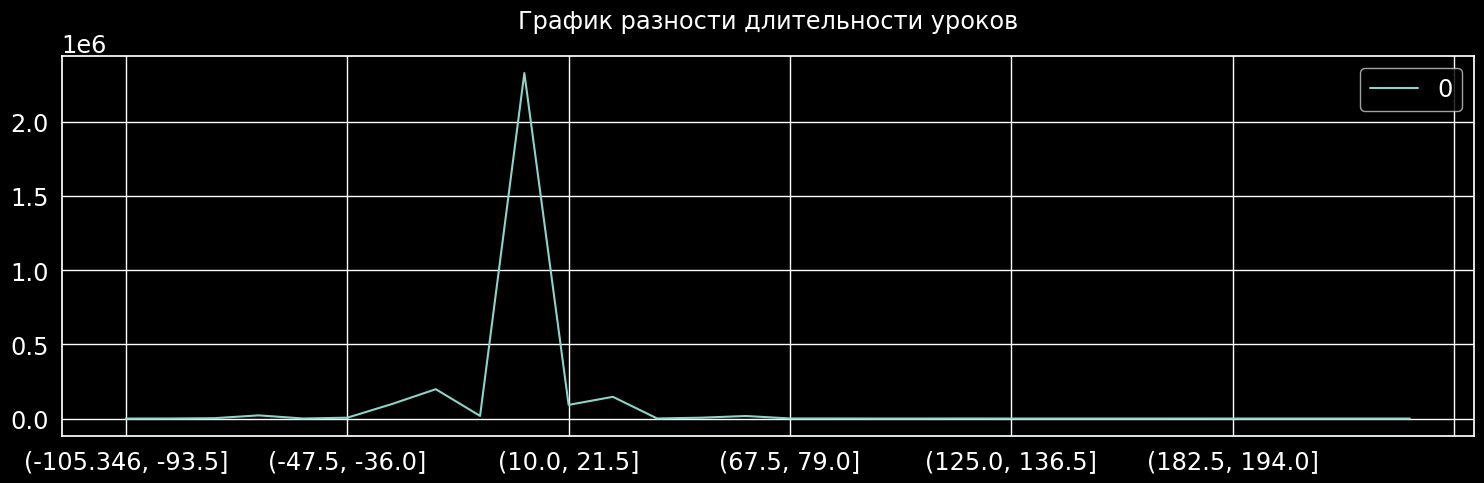

In [143]:
(df['lesson_duration_x'] - df['lesson_duration_y']). value_counts(bins= 30).to_frame().sort_index().plot(title = 'График разности длительности уроков')
plt. show()

In [144]:
# Посмотрим количество уникальных значений в колонках lesson_duration_y и lesson_duration_x.

df['lesson_duration_x'].value_counts().to_frame(), df['lesson_duration_y'].value_counts().to_frame()

(     lesson_duration_x
 60             2497879
 45              197894
 90              162582
 40               21642
 30               20264
 50               12022
 120              11349
 55                5116
 80                1805
 180                388
 70                 347
 75                 314
 35                 223
 135                148
 100                137
 48                  48
 240                 42
 160                 32
 130                 15
 33                  11
 105                 10
 150                  8
 68                   6
 85                   6
 42                   5
 65                   4
 110                  4
 25                   3
 20                   2
 34                   1,
      lesson_duration_y
 60             2691898
 45              111980
 90               94158
 120              24743
 0                 8685
 135                843)

In [145]:
# Заполним 0 значения lesson_duration_y наиболее частым в обеих колонках значением - 60 мин и удалим lesson_duration_х.

df.loc[df['lesson_duration_y'] == 0,'lesson_duration_y'] = 60

In [146]:
df.drop('lesson_duration_x', axis = 1, inplace = True)

status_id_new            0       1    Total
sex   teacher_sex                          
1     0              19553    6571    26124
      1              74584   40230   114814
      2               4304    1184     5488
      3             430035  162939   592974
2     0              30919   11158    42077
      1               1821     603     2424
      2             771952  323999  1095951
      3             745557  306898  1052455
Total              2078725  853582  2932307


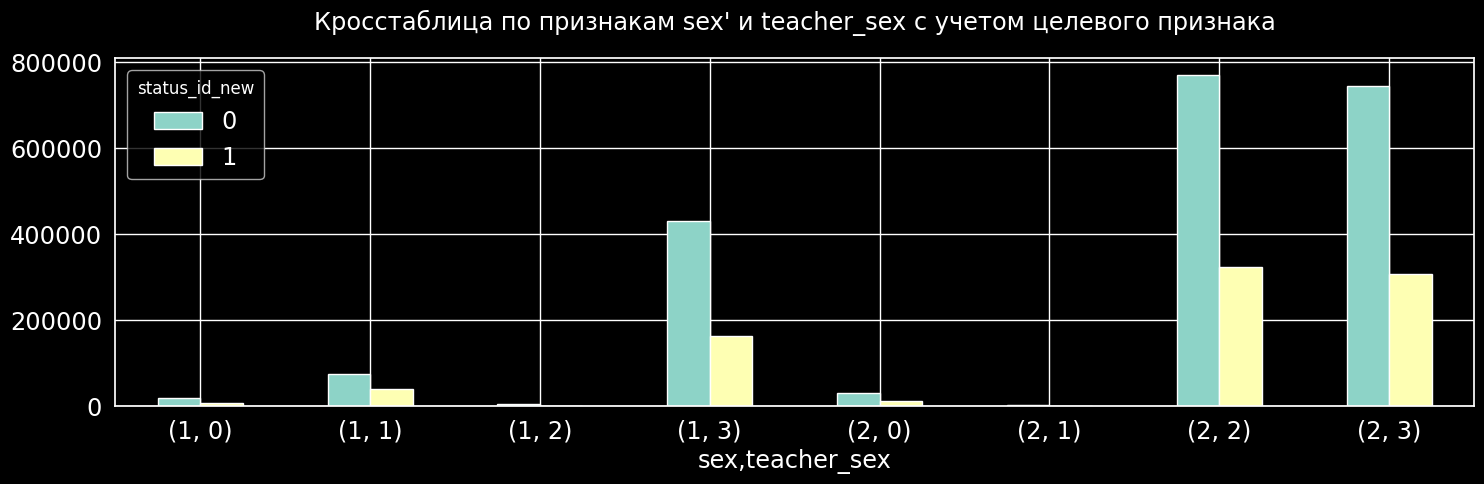

In [147]:
# Построим кросстаблицу

pprint(
    pd.crosstab(
        [df['sex'], df['teacher_sex']],df['status_id_new'], margins=True, margins_name="Total"
    )
)
pd.crosstab([df['sex'], df['teacher_sex']],df['status_id_new']).plot.bar(rot=0).set_title(
    "Кросстаблица по признакам sex' и teacher_sex c учетом целевого признака"
)
plt.show()

In [148]:
# Удалим колонку teacher_sex,т.к. колонка sex обладает более полной информацией.

df. drop('teacher_sex', axis= 1,inplace = True)

In [149]:
#

# Создадим списки категориальных данных и числовых.

cat_type_less = []
cat_type_more = []

for col in df.select_dtypes(include="category").columns.to_list():
  if df[col].nunique() <= 5:
    cat_type_less.append(col)
  else:
    cat_type_more.append(col)

cat_type_less.remove('status_id_new')


numeric_type = df.select_dtypes(
    exclude=["category"]
).columns.tolist()



pprint(f' cat_type_more: {cat_type_more}')
print("\n")
pprint(f' cat_type_less: {cat_type_less}')
print("\n")
numeric_type

(" cat_type_more: ['teacher_id', 'order_id', 'user_id', 'status_id', "
 "'russian_level_id', 'home_country_id', 'rating_id', 'area_id', 'id_y', "
 "'subject_id', 'home_metro_id', 'pupil_category_new_id', 'lesson_place_new', "
 "'source_id', 'original_order_id']")


(" cat_type_less: ['enable_auto_assign', 'enable_assign', 'is_home_lessons', "
 "'is_external_lessons', 'status_display', 'is_confirmed', 'photo_path', "
 "'is_display', 'sex', 'is_remote_lessons', 'show_on_map', 'send_mailing', "
 "'send_suitable_orders', 'is_edited', 'orders_allowed', "
 "'verification_status_id', 'is_display_at_partners', 'pupil_knowledgelvl', "
 "'chosen_teachers_only', 'no_teachers_available', 'is_display_to_teachers']")




['lesson_cost',
 'rating',
 'effective_rating',
 'rating_for_users',
 'rating_for_admin',
 'display_days',
 'star_rating',
 'rating_for_users_yesterday',
 'review_num',
 'reg_date_numb',
 'birth_date_numb',
 'teaching_start_date_numb',
 'rules_confirmed_date_numb',
 'relevance_date_numb',
 'last_visited_numb',
 'lesson_duration_y',
 'planned_lesson_number',
 'lessons_per_week',
 'teacher_experience_from',
 'teacher_age_from']

Баланс классов:

0   0.71
1   0.29
Name: status_id_new, dtype: float64




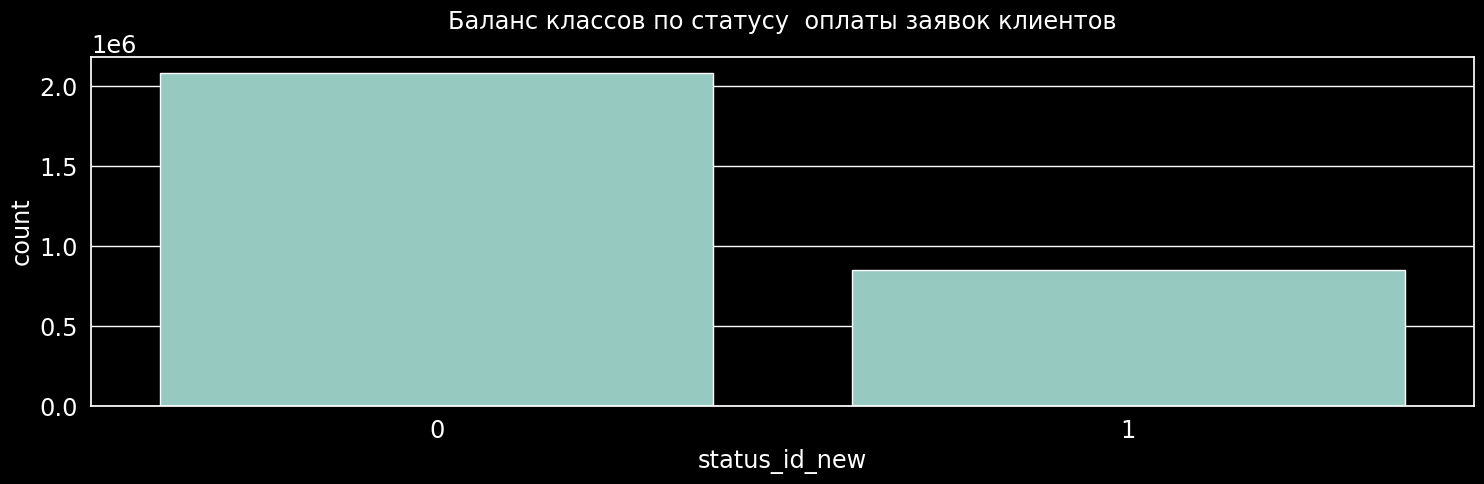

In [150]:
# Взглянем на баланс классов таргета.


print(f'Баланс классов:\n\n{df.status_id_new.value_counts(normalize=True)}\n\n')
sns.countplot(data=df, x=df.status_id_new).set_title(
    "Баланс классов по статусу  оплаты заявок клиентов"
);

In [151]:
# Создадим функцию для анализа категориальных признаков в разбивке по таргету.


def category_plot(dataframe, category_list=cat_type_less, rows=11, cols=2):
    """Функция принимает в качестве аргументов: датафрейм, список названий признаков,
    количество колонок и строк будущих графиков. Возвращает готовые графики по каждому признаку.
    """
    plt.figure(figsize=(20, 35))
    for idx, col in enumerate(category_list):
        ax = plt.subplot(rows, cols, idx + 1)
        sns.countplot(data=dataframe, x=col, hue="status_id_new").set_xlabel("")
        plt.title(col.upper(), fontsize=40)
        plt.xticks(rotation=10, fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel("Количество", fontsize=20)
        plt.subplots_adjust(hspace=0.5)
        plt.subplots_adjust(wspace=0.3)
    plt.show()

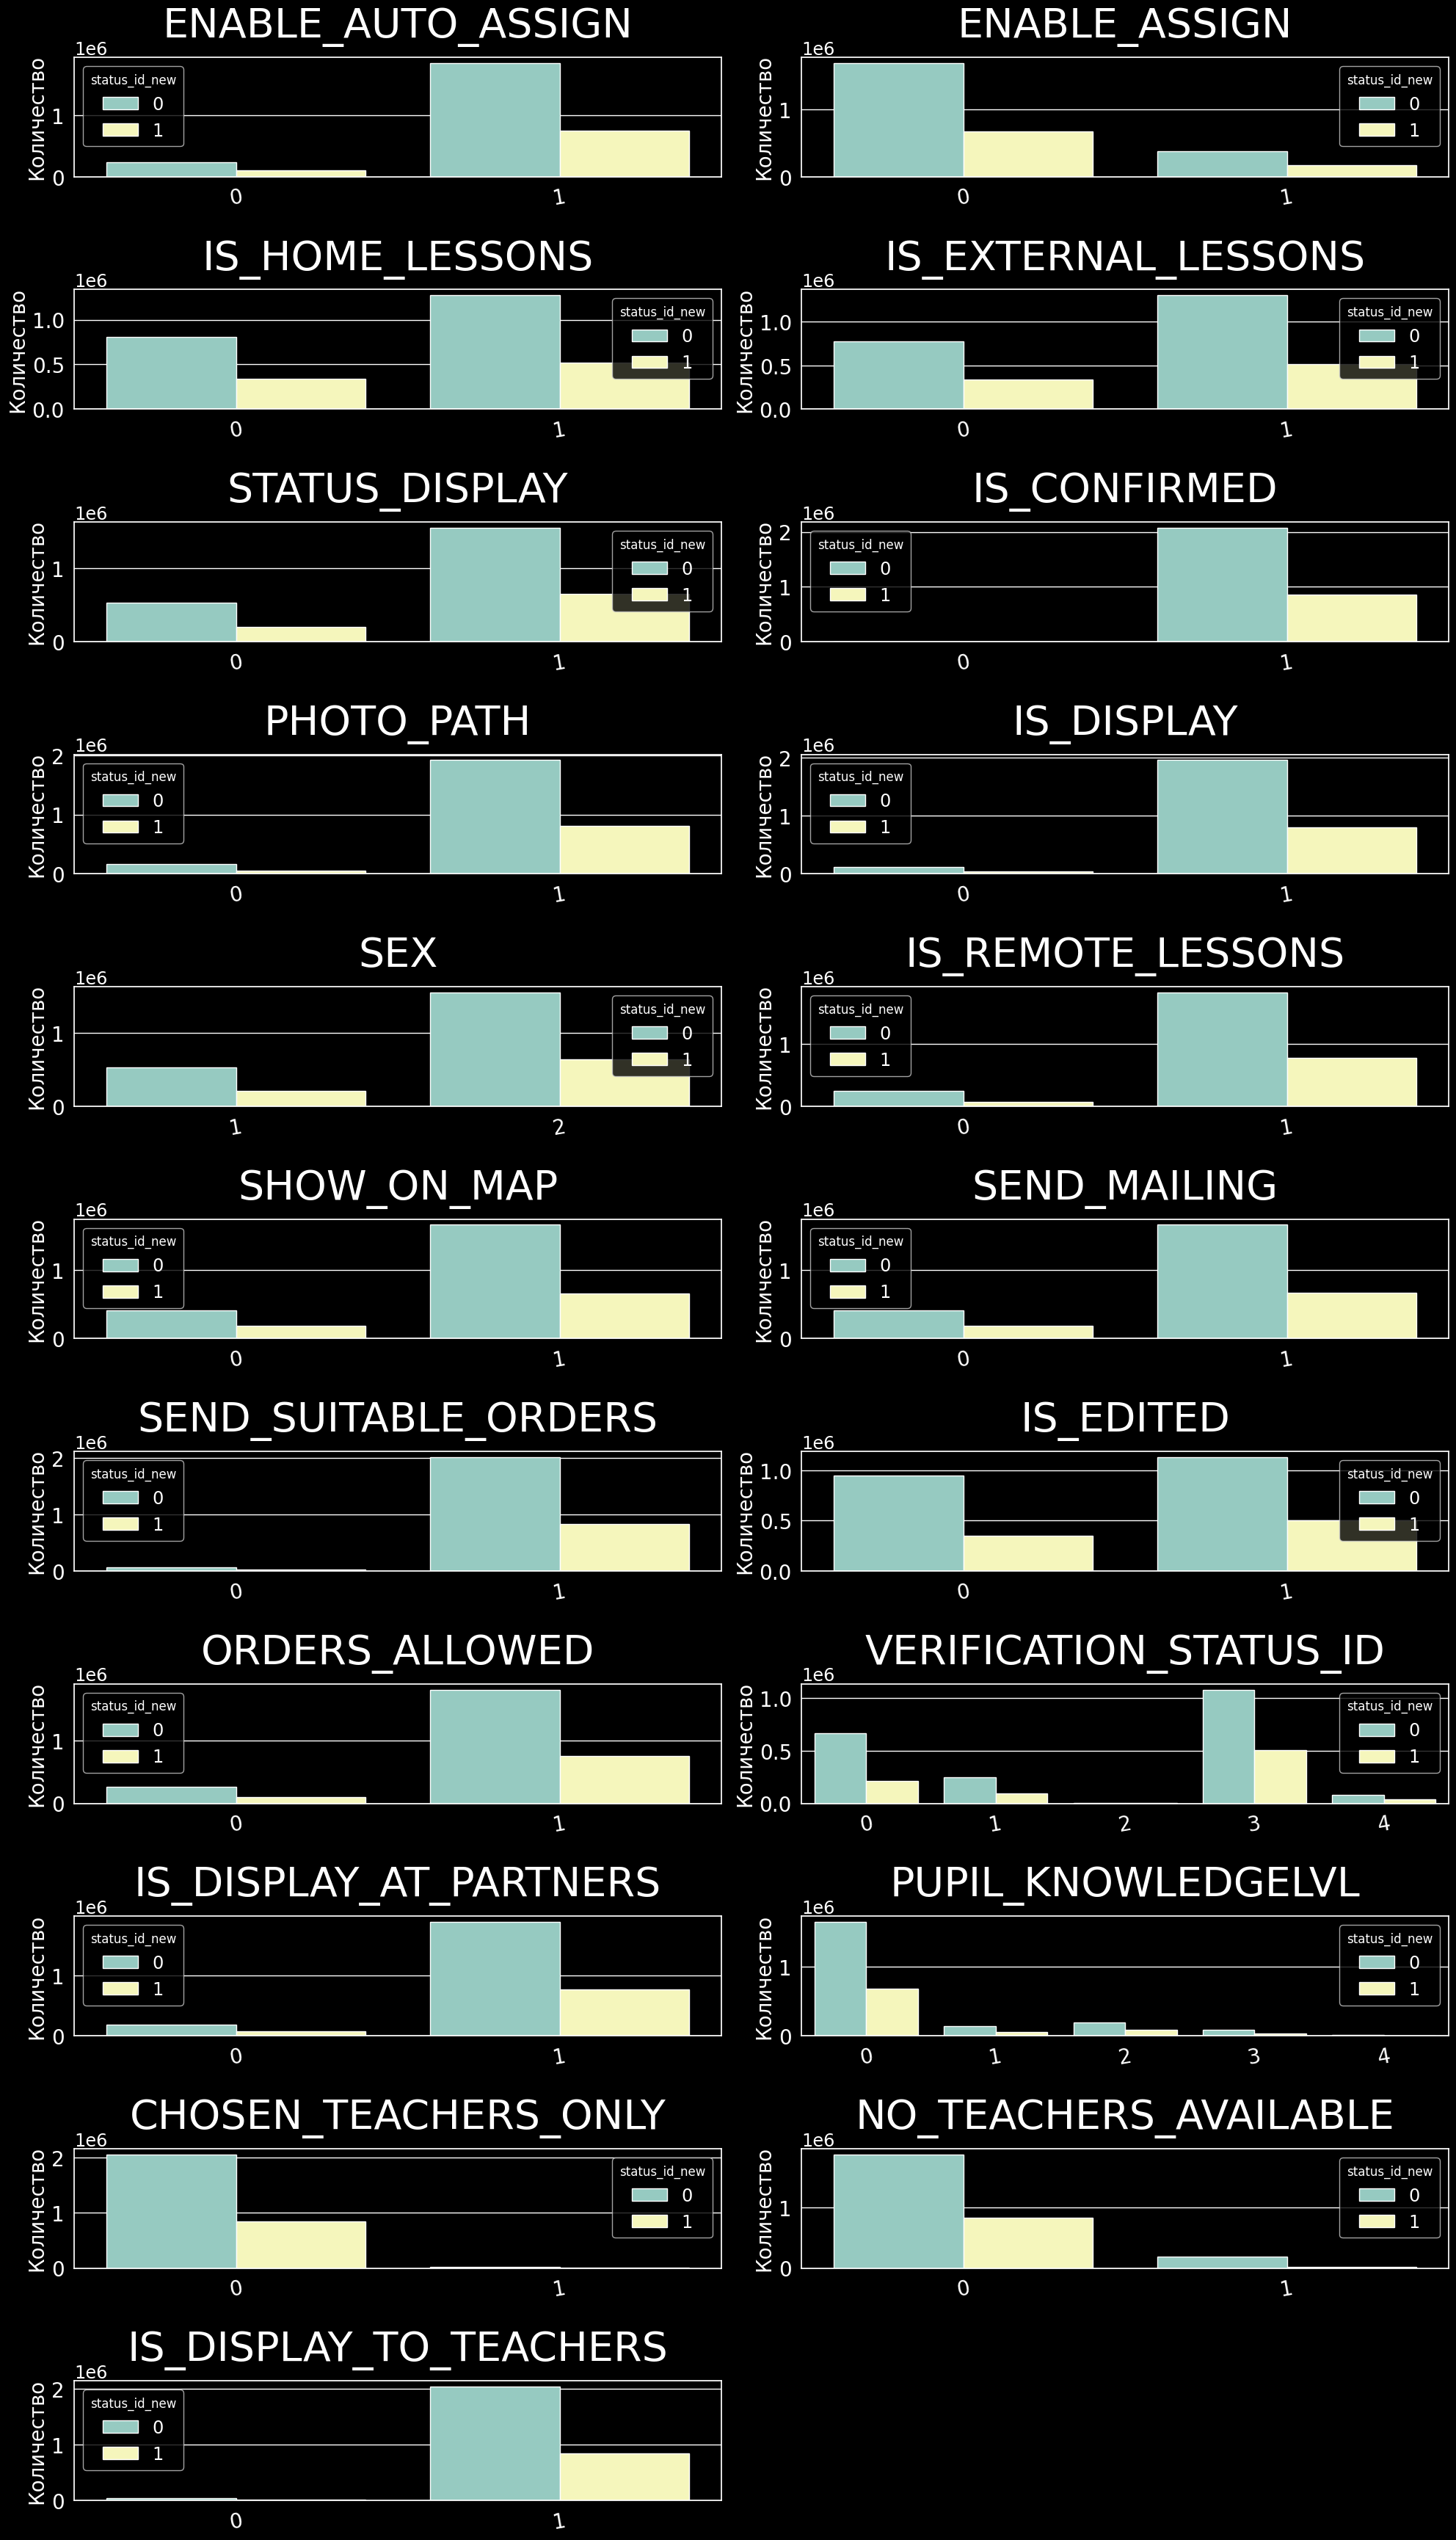

In [152]:
# Построим графики с помощью функции выше.

category_plot(df)

In [153]:
# Уберём из списка id клиентов, заявок, оригинальных заявок.


cat_type_more = [m for m in cat_type_more if m not in ['teacher_id',
 'order_id','user_id', 'id_y','original_order_id','home_metro_id','home_country_id','area_id',]]
special_cat_type = ['home_metro_id','home_country_id','area_id']
cat_type_more

['status_id',
 'russian_level_id',
 'rating_id',
 'subject_id',
 'pupil_category_new_id',
 'lesson_place_new',
 'source_id']

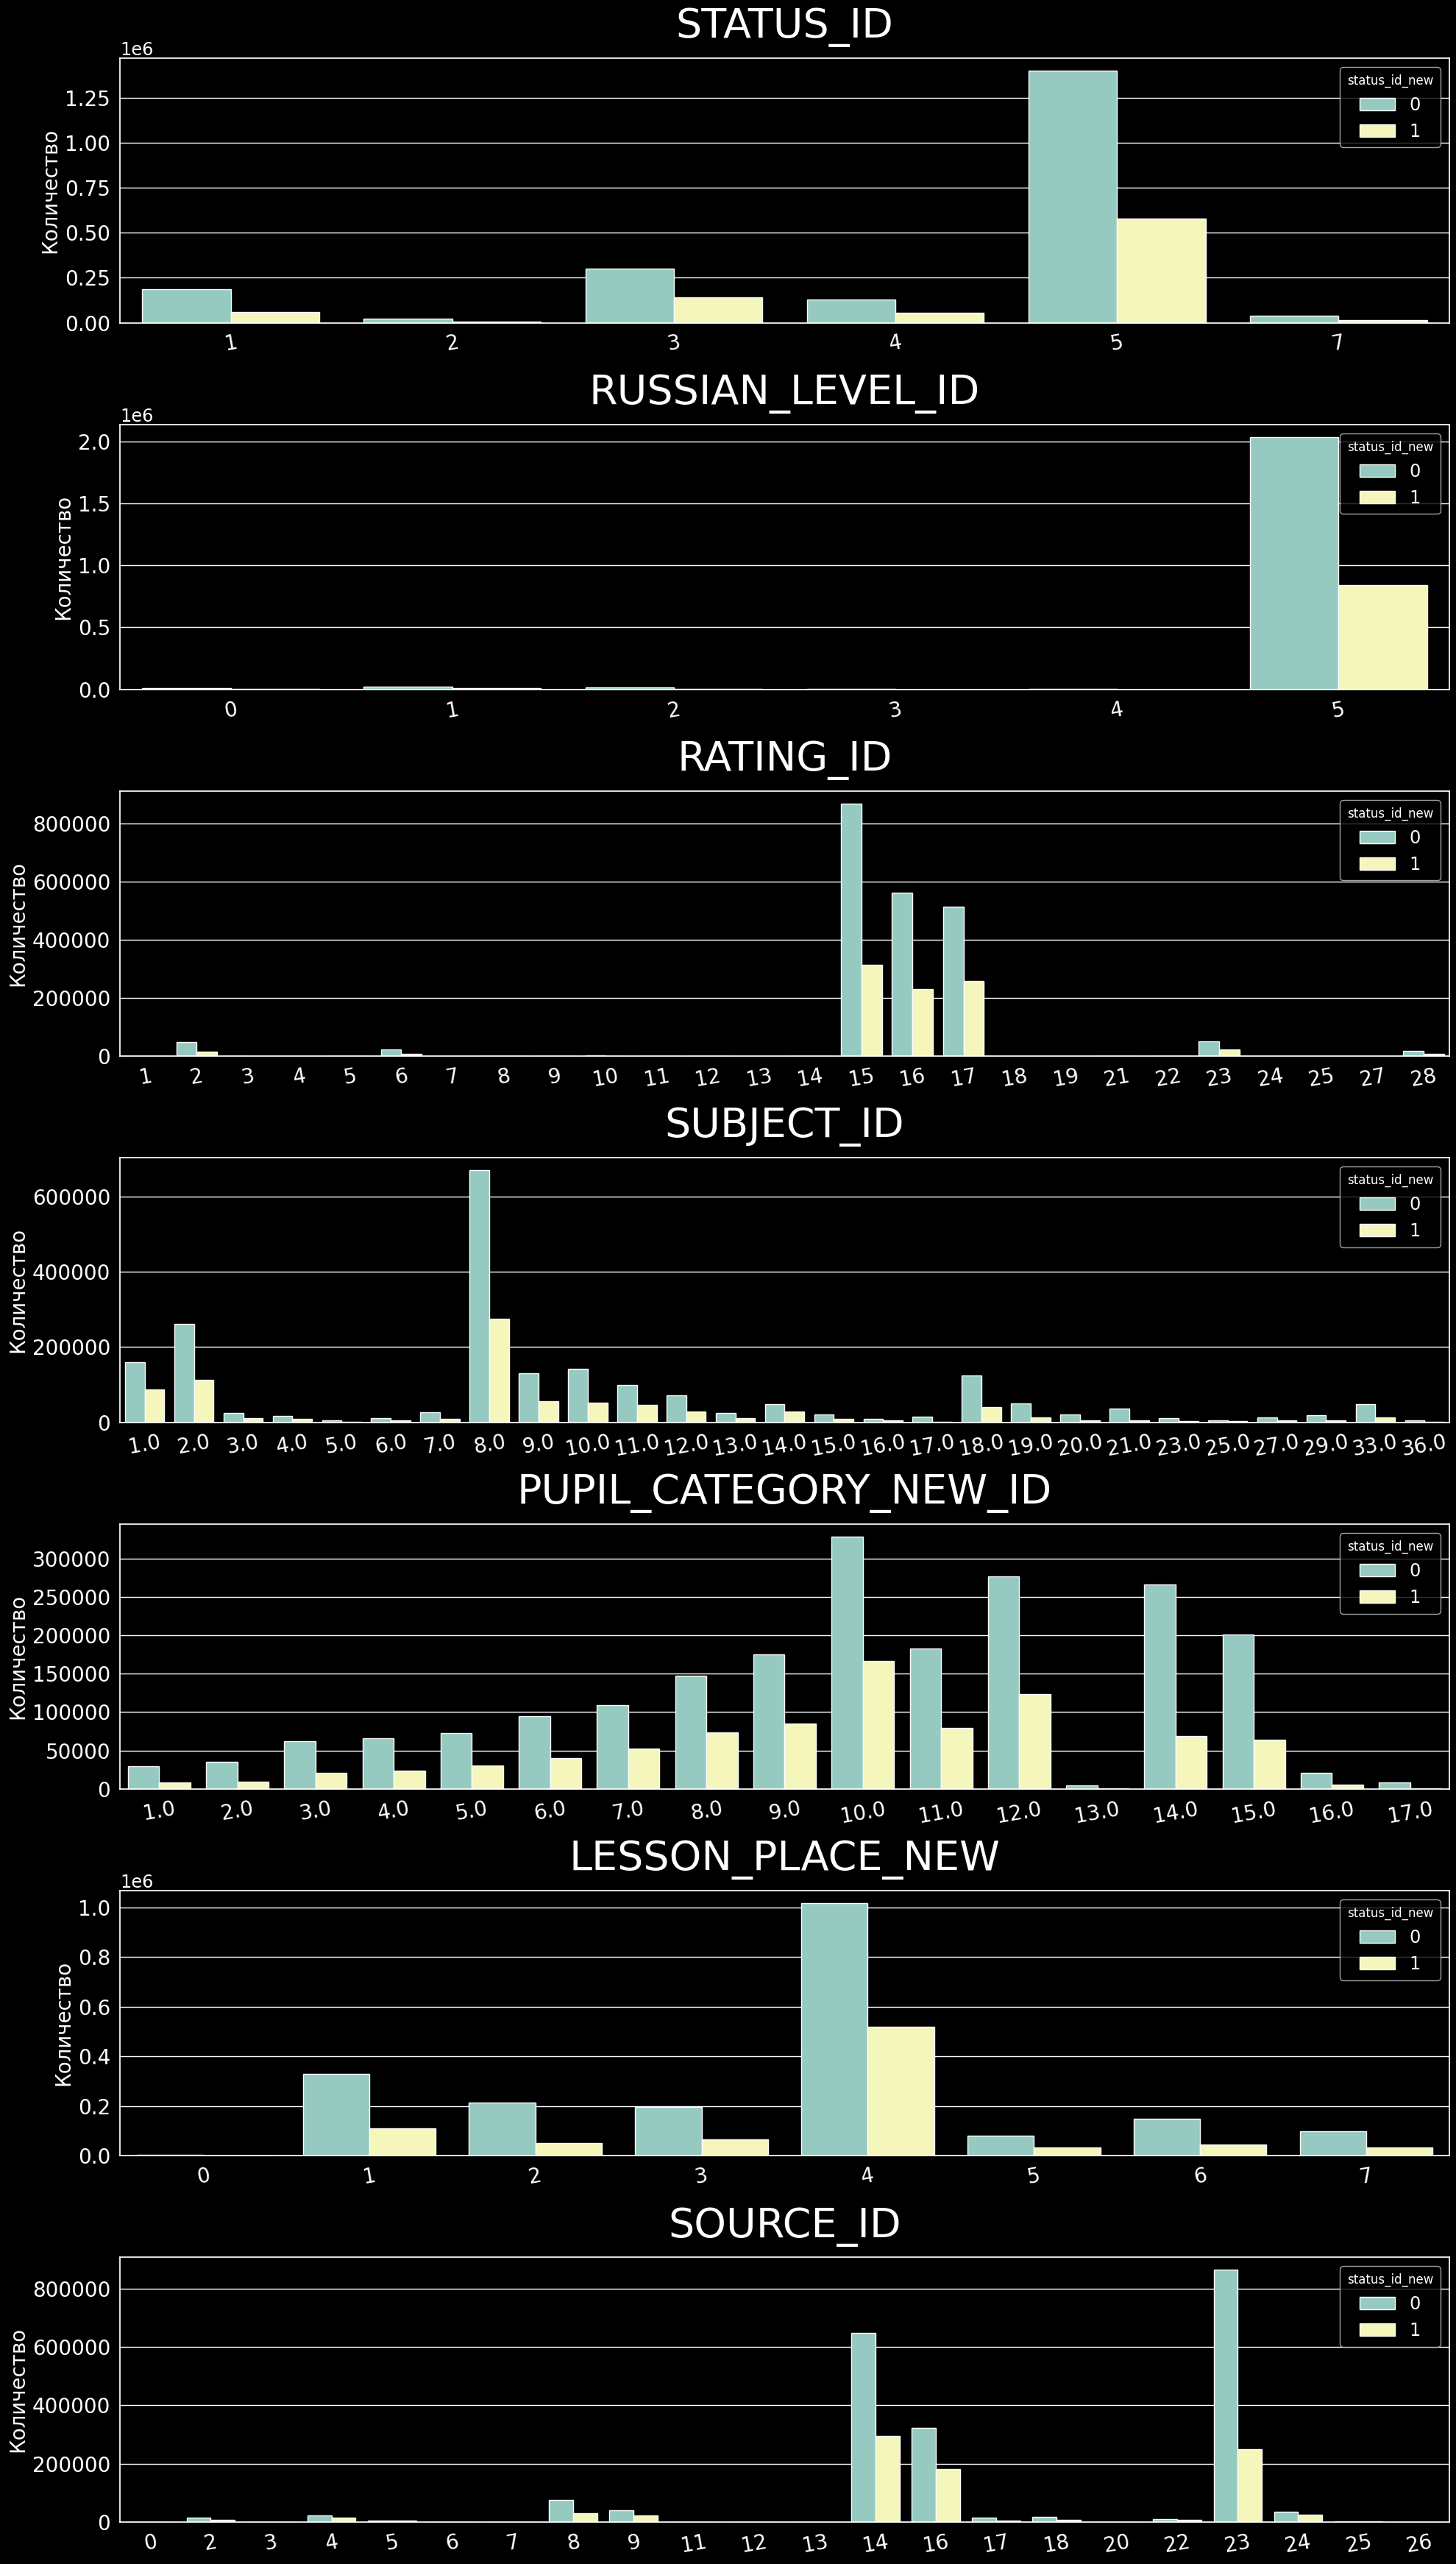

In [154]:
# Построим графики с помощью функции выше.

category_plot(df,cat_type_more,7,1)

In [155]:
# Построим более подробно на данные с помощью кросстаблицы.

for col in [ 'send_suitable_orders',
'chosen_teachers_only','russian_level_id','is_confirmed','send_suitable_orders']:
     print(pd.crosstab(df['status_id_new'], df[col], margins=True, margins_name="Total"),'\n\n\n')

send_suitable_orders      0        1    Total
status_id_new                                
0                     63855  2014870  2078725
1                     28048   825534   853582
Total                 91903  2840404  2932307 



chosen_teachers_only        0      1    Total
status_id_new                                
0                     2058230  20495  2078725
1                      839978  13604   853582
Total                 2898208  34099  2932307 



russian_level_id     0      1      2     3     4        5    Total
status_id_new                                                     
0                 6789  22452  13476  1419  1108  2033481  2078725
1                 1510   7889   4272   498   402   839011   853582
Total             8299  30341  17748  1917  1510  2872492  2932307 



is_confirmed     0        1    Total
status_id_new                       
0               95  2078630  2078725
1               19   853563   853582
Total          114  2932193  2932307 



send

In [156]:
# Удалим колонку is_confirmed,т.к. неподтвержденных заявок очень мало.

df. drop('is_confirmed', axis= 1,inplace = True)

In [157]:
# Удалим колонку is_display_to_teachers,т.к. заказав не показанных репетиторам достаточно мало.

df. drop('is_display_to_teachers', axis= 1,inplace = True)

In [158]:
# Удалим колонку send_suitable_orders,т.к. чаще всего отравляют более  удобные заказы.

df. drop('send_suitable_orders', axis= 1,inplace = True)

In [159]:
# Удалим колонку russian_level_id,т.к. чаще всего используется категория 5, как среди оплаченных заказов, так и среди не оплаченных.

df. drop('russian_level_id', axis= 1,inplace = True)

In [160]:
# Построим более подробно на данные с помощью кросстаблицы.

for col in special_cat_type:
     print(pd.crosstab(df['status_id_new'], df[col], margins=True, margins_name="Total"),'\n\n\n')

home_metro_id   -666.0   1.0  3.0   4.0   5.0  6.0  7.0  8.0  9.0  10.0  11.0  \
status_id_new                                                                   
0               965301  1590  291  1953  1246  352   54  418  437    31   286   
1               478735   517  196   805   552  161  129  231  210     7   111   
Total          1444036  2107  487  2758  1798  513  183  649  647    38   397   

home_metro_id  12.0  13.0  14.0  15.0  16.0  17.0  18.0  19.0  20.0  21.0  \
status_id_new                                                               
0                53   296   226   808   536   111  2160  1998  3135  1584   
1                12    97   192   517   274    30  1145   911  1359   765   
Total            65   393   418  1325   810   141  3305  2909  4494  2349   

home_metro_id  22.0  24.0  25.0  26.0  27.0  28.0  29.0  30.0  31.0  32.0  \
status_id_new                                                               
0              2007  1786  1419  1694   898   137   42

In [161]:
# Удалим колонку home_metro_id ,т.к. большая часть информации пропущено и заменено заглушкой.

df. drop('home_metro_id', axis= 1,inplace = True)

In [162]:
# Обновим список numeric_type.

numeric_type = [k for k in numeric_type if k not in ['teacher_id',
 'order_id',
 'lesson_duration_x']]

**lesson_cost**

In [205]:
# Округлим значения в колонке lesson_cost.

df["lesson_cost"] =df["lesson_cost"].apply(lambda x: np.ceil(x))

Распределение стоимости за урок


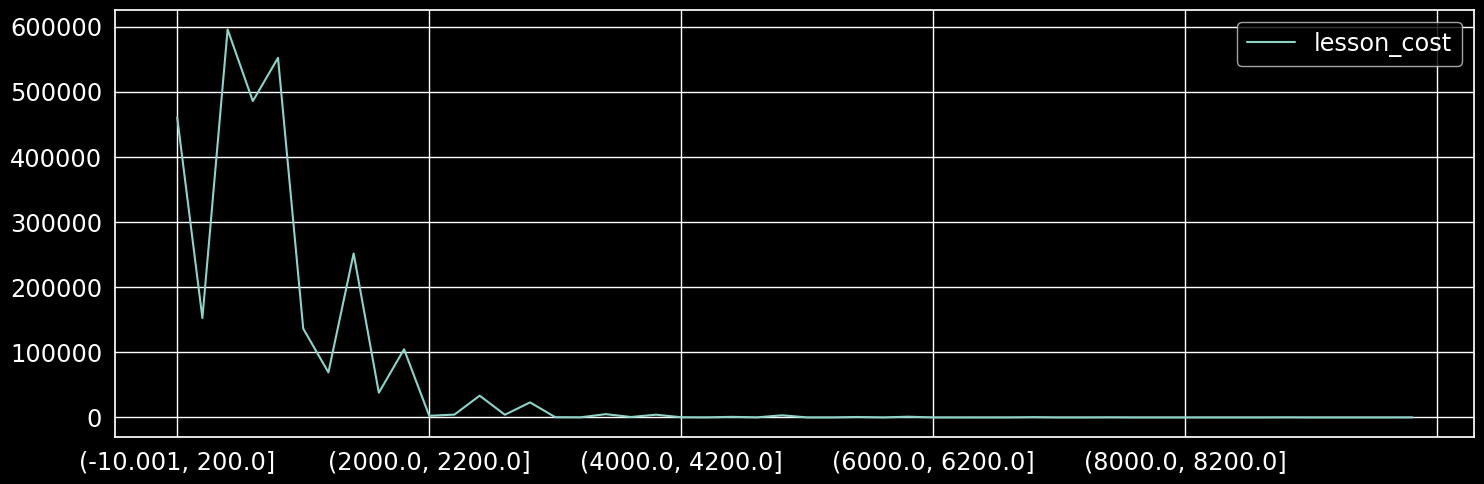

In [206]:
# Посторим график.

print('Распределение стоимости за урок')
df["lesson_cost"].value_counts(bins = 50).to_frame().sort_index().plot()
plt.show()

In [215]:
# Посмотрим сколько значений находятся на миниммальном пороге стоимости и минусовом.

df.query('lesson_cost <200 & lesson_cost >-20 & status_id_new == 1')['lesson_cost'].shape

(116712,)

In [216]:
# Посмотрим сколько значений находятся на миниммальном пороге стоимости и минусовом.

df.query('lesson_cost <200 & lesson_cost >-20 & status_id_new == 0')['lesson_cost'].shape

(343572,)

In [218]:
# Заменим эти значения на минимальную сумму - 200 р.

df.loc[df.query('lesson_cost <200 & lesson_cost >-20').index.to_list(), ['lesson_cost']] = 200

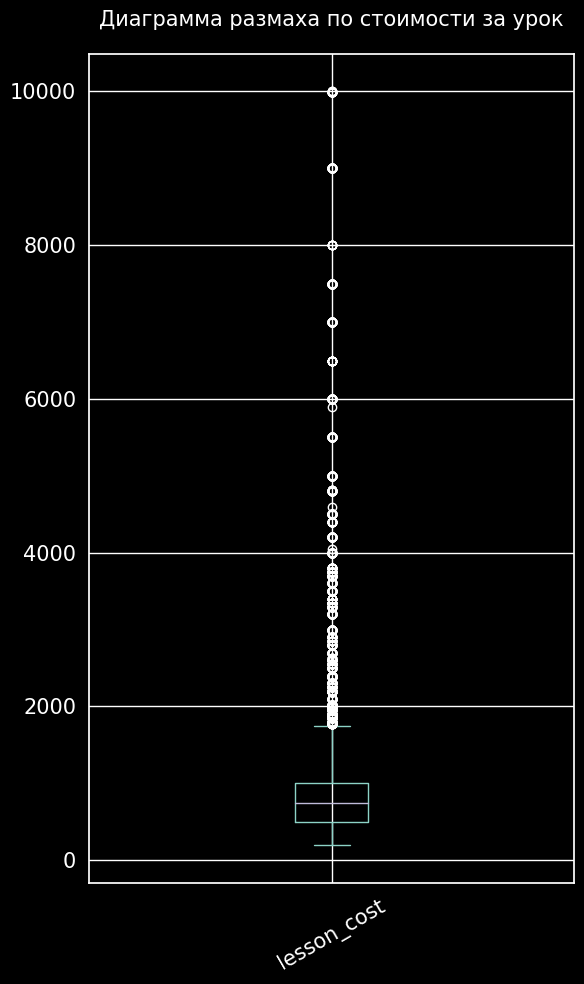

In [225]:
# Построим диаграмму размаха.

plt.figure(figsize=(6, 10))
df['lesson_cost'].plot(kind="box").set_title(
    "Диаграмма размаха по стоимости за урок", fontsize=15
)
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

**rating**

In [249]:
# Посмотрим на распределение.

print('Распределение стоимости за урок')
df["rating"].value_counts(bins = 10).to_frame().sort_index()


Распределение стоимости за урок


,rating
"(-100600.511, -90449.0]",23266
"(-90449.0, -80398.0]",0
"(-80398.0, -70347.0]",0
"(-70347.0, -60296.0]",0
"(-60296.0, -50245.0]",0
"(-50245.0, -40194.0]",0
"(-40194.0, -30143.0]",0
"(-30143.0, -20092.0]",0
"(-20092.0, -10041.0]",0
"(-10041.0, 10.0]",2909041


In [250]:
# Посмотрим на количество значений при условии rating больше -10041.0.

df.query('rating >-10041.0')['rating'].value_counts().to_frame().sort_index() #-30, -25, -17, -14, -12, -100500

,rating
-30,79
-25,197
-17,6
-14,476
-12,14
-10,912
-8,2
-7,630
-5,30346
-4,73


In [251]:
# Посмотрим на количество значений при условии rating меньше -10041.0.

df.query('rating <-10041.0')['rating'].value_counts().to_frame().sort_index()

,rating
-100500,23266


In [254]:
# Заменим значения колонки rating -30, -25, -17, -14, -12, -100500 на -10.

df.loc[df['rating'].isin([-30, -25, -17, -14, -12, -100500]),'rating'] = -10

In [255]:
# Изменим тип данных.

df['rating'] = df['rating'].astype('category')

**effective_rating**

In [267]:
# Округлим значения в колонке lesson_cost.

df["effective_rating"] =df["effective_rating"].apply(lambda x: np.ceil(x))

In [274]:
#  Посмотрим на распределение.

print('Распределение стоимости за урок')
df["effective_rating"].value_counts(bins=60).to_frame().sort_index()


Распределение стоимости за урок


,effective_rating
"(-232.35, -31.85]",5707
"(-31.85, 157.3]",2926360
"(157.3, 346.45]",0
"(346.45, 535.6]",0
"(535.6, 724.75]",0
"(724.75, 913.9]",0
"(913.9, 1103.05]",0
"(1103.05, 1292.2]",0
"(1292.2, 1481.35]",0
"(1481.35, 1670.5]",0


In [275]:
# Посмотрим на выбивающиеся значения.

df.query('effective_rating > 10938')['effective_rating'].value_counts().to_frame().sort_index()

,effective_rating
"11,112.00",18
"11,120.00",201
"11,128.00",21


In [277]:
# Заменим значения на ближайшее.

df.loc[df['effective_rating'] > 10938, 'effective_rating'] = 10

In [280]:
# Посмотрим на распределение.

df.query('effective_rating >= -10 & effective_rating <= 10')['effective_rating'].value_counts().to_frame().sort_index()

,effective_rating
-10.00,40
-9.00,90
-8.00,45
-7.00,992
-6.00,3230
-5.00,785
-4.00,1035
-3.00,1547
-2.00,4936
-1.00,641


In [281]:
# Заменим значения на ближайшее.

df.loc[df['effective_rating'] > 10, 'effective_rating'] = 10
df.loc[df['effective_rating'] < -10, 'effective_rating'] = -10

In [283]:
# Изменим тип данных.

df['effective_rating'] = df['effective_rating'].astype('category')

**rating_for_users**

In [288]:
#

df['rating_for_users'].value_counts(bins=30)

(565.333, 1130.667]               853479
(-16.961000000000002, 565.333]    735856
(1130.667, 1696.0]                585952
(1696.0, 2261.333]                300731
(2261.333, 2826.667]              153447
(2826.667, 3392.0]                124741
(3392.0, 3957.333]                 86146
(3957.333, 4522.667]               41943
(4522.667, 5088.0]                 20857
(5088.0, 5653.333]                 10738
(5653.333, 6218.667]                7276
(6218.667, 6784.0]                  3904
(6784.0, 7349.333]                  1736
(7349.333, 7914.667]                1568
(10741.333, 11306.667]              1247
(14698.667, 15264.0]                 598
(7914.667, 8480.0]                   552
(9045.333, 9610.667]                 513
(8480.0, 9045.333]                   418
(16394.667, 16960.0]                 236
(10176.0, 10741.333]                 233
(9610.667, 10176.0]                  135
(15829.333, 16394.667]                 1
(11306.667, 11872.0]                   0
(11872.0, 12437.

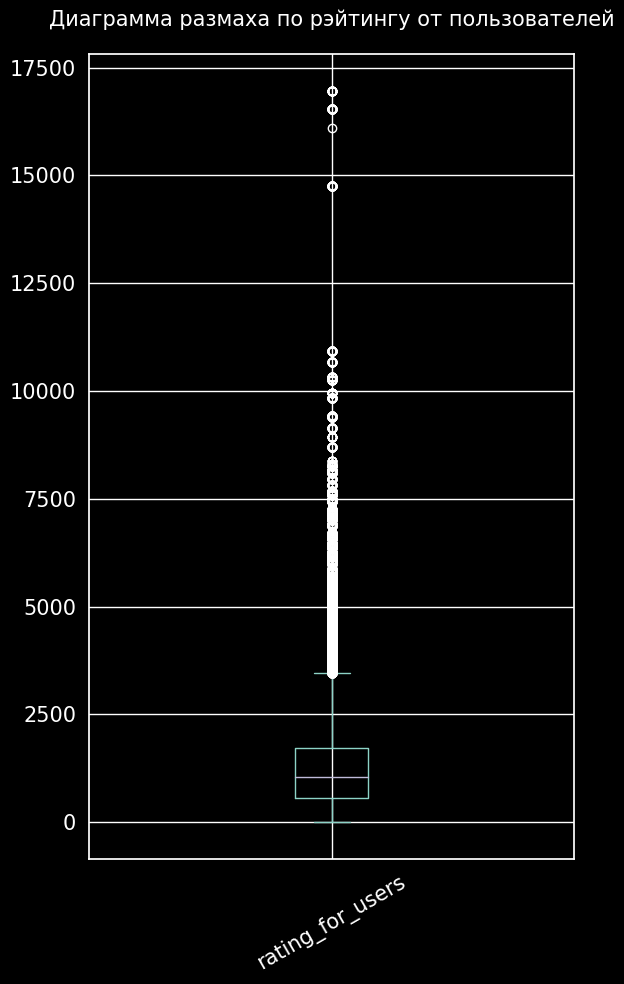

In [304]:
# Построим диаграмму размаха.

plt.figure(figsize=(6, 10))
df['rating_for_users'].plot(kind="box").set_title(
    "Диаграмма размаха по рэйтингу от пользователей", fontsize=15
)
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

**rating_for_admin**

In [306]:
#

df['rating_for_admin'].value_counts(bins=30)

(-20.993000000000002, 699.733]    2031512
(699.733, 1399.467]                637272
(1399.467, 2099.2]                 173960
(2099.2, 2798.933]                  53271
(2798.933, 3498.667]                17244
(3498.667, 4198.4]                   8389
(4198.4, 4898.133]                   3158
(4898.133, 5597.867]                 2441
(6997.333, 7697.067]                 1749
(5597.867, 6297.6]                   1678
(11195.733, 11895.467]                598
(6297.6, 6997.333]                    426
(11895.467, 12595.2]                  285
(9796.267, 10496.0]                   136
(7697.067, 8396.8]                    120
(13294.933, 13994.667]                 52
(9096.533, 9796.267]                   15
(20292.267, 20992.0]                    1
(12595.2, 13294.933]                    0
(8396.8, 9096.533]                      0
(13994.667, 14694.4]                    0
(14694.4, 15394.133]                    0
(15394.133, 16093.867]                  0
(16093.867, 16793.6]              

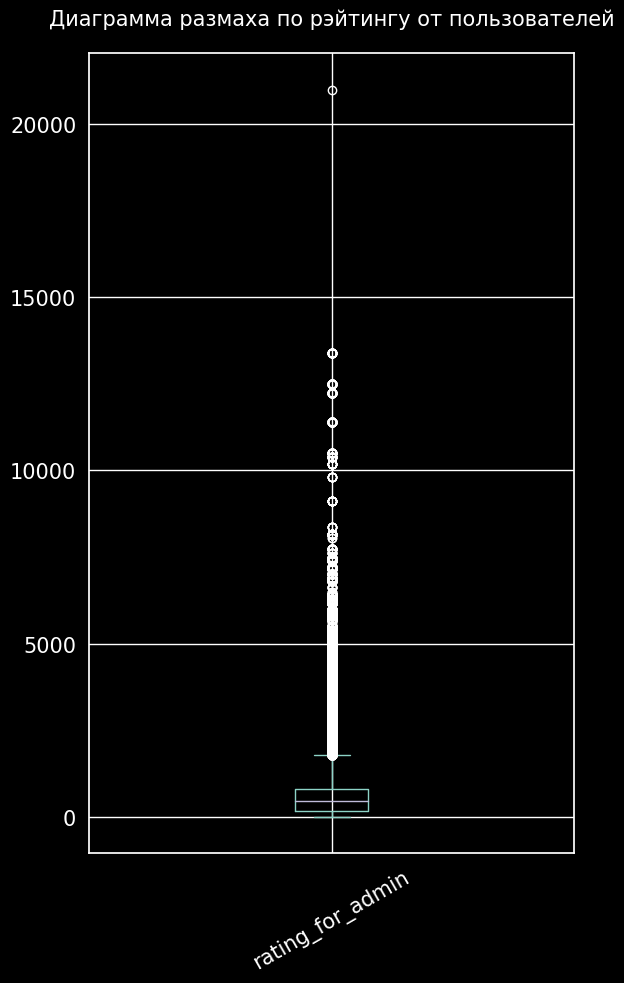

In [307]:
# Построим диаграмму размаха.

plt.figure(figsize=(6, 10))
df['rating_for_admin'].plot(kind="box").set_title(
    "Диаграмма размаха по рэйтингу от администраторов", fontsize=15
)
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

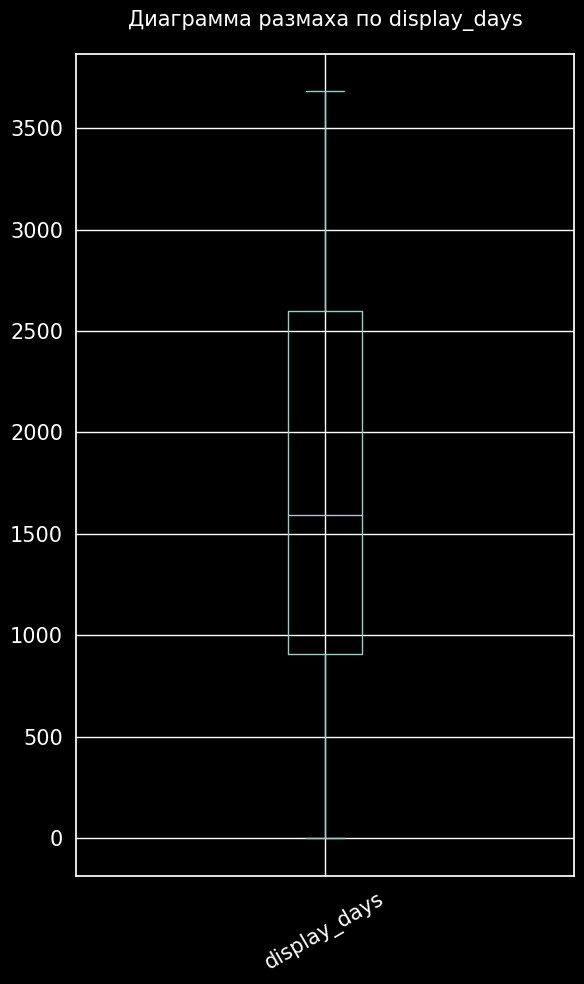

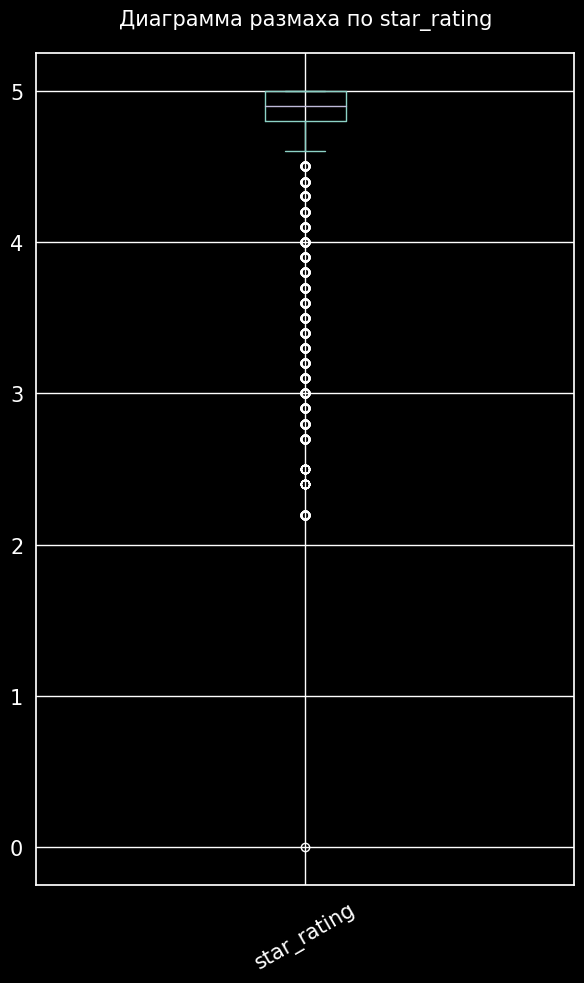

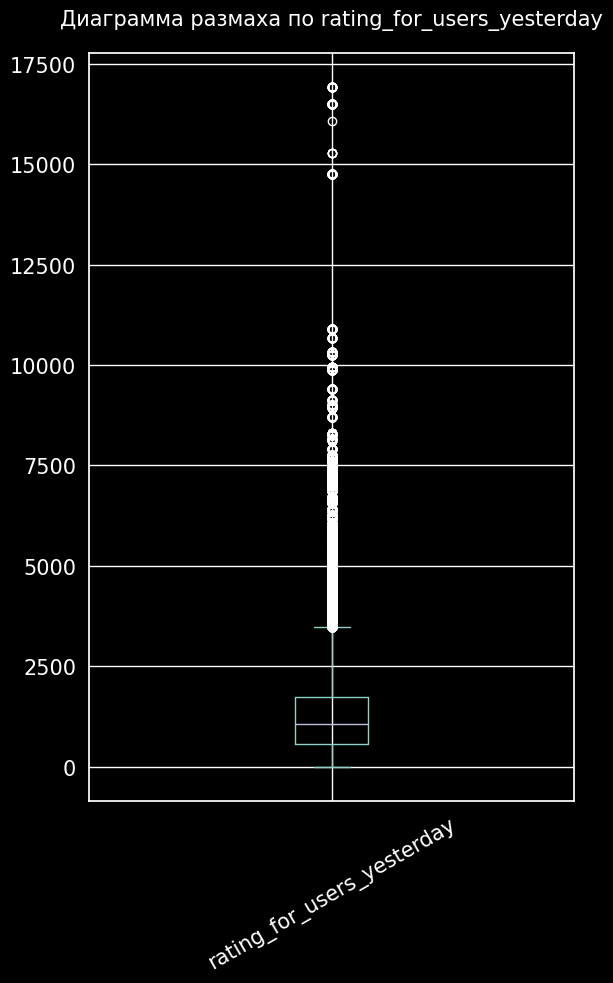

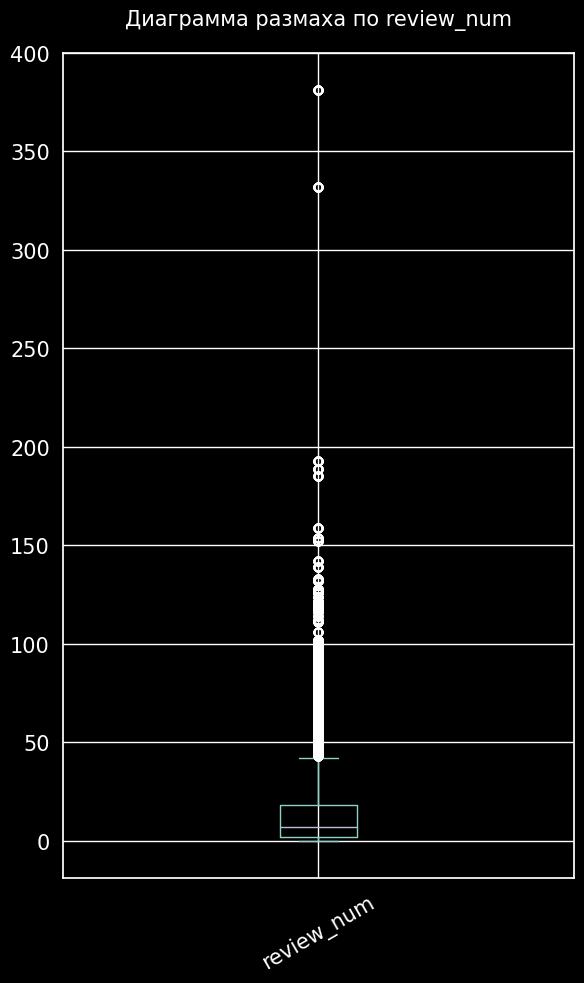

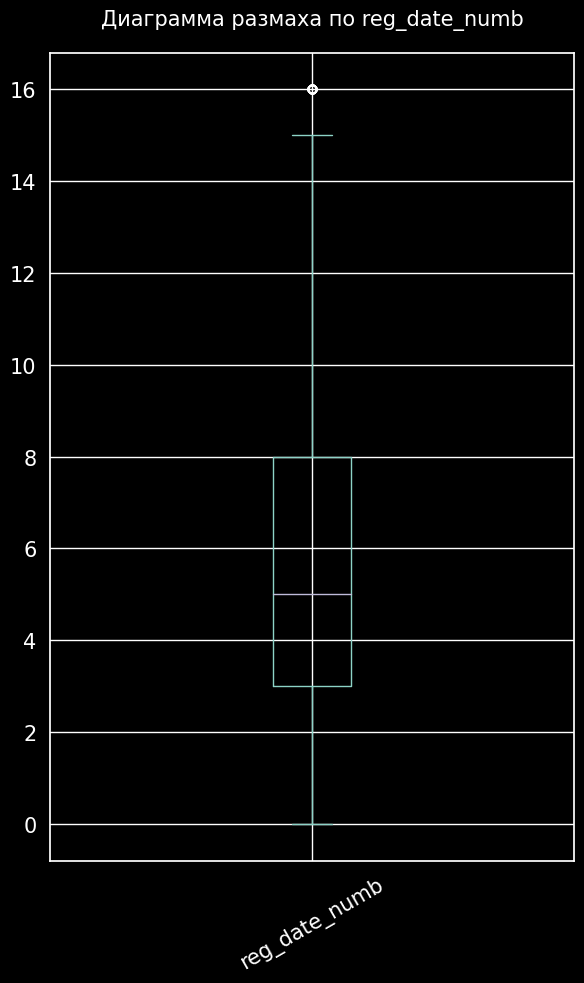

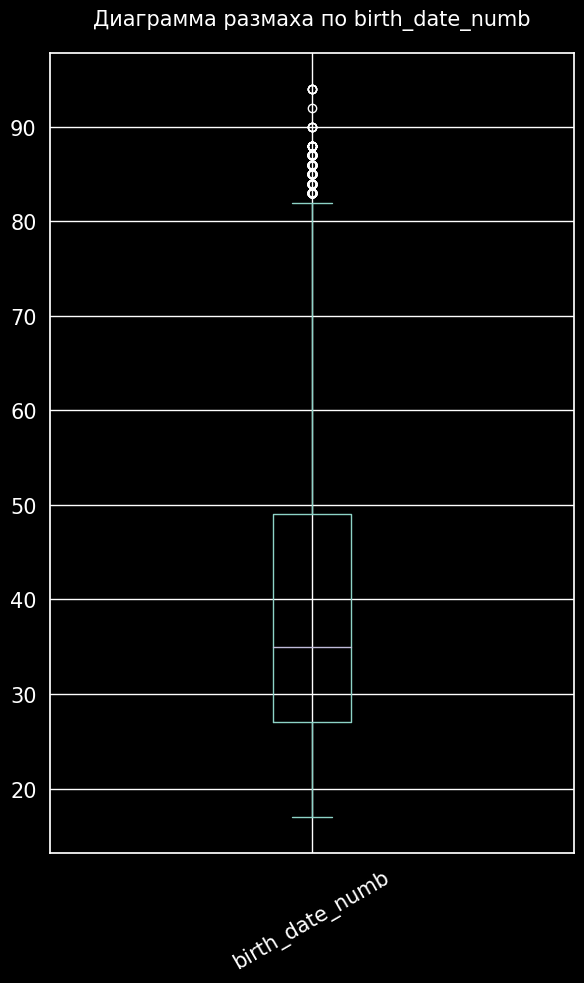

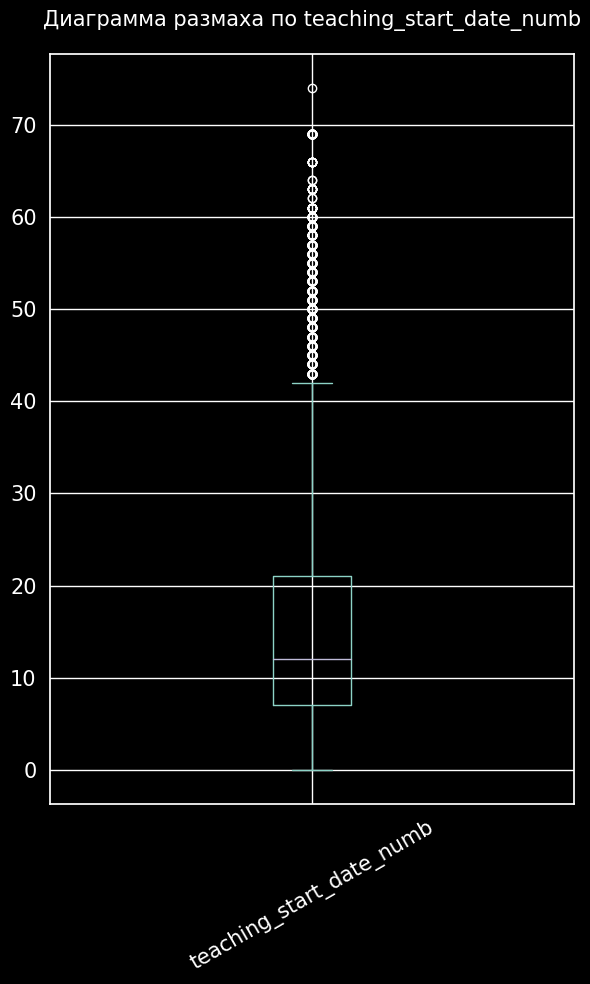

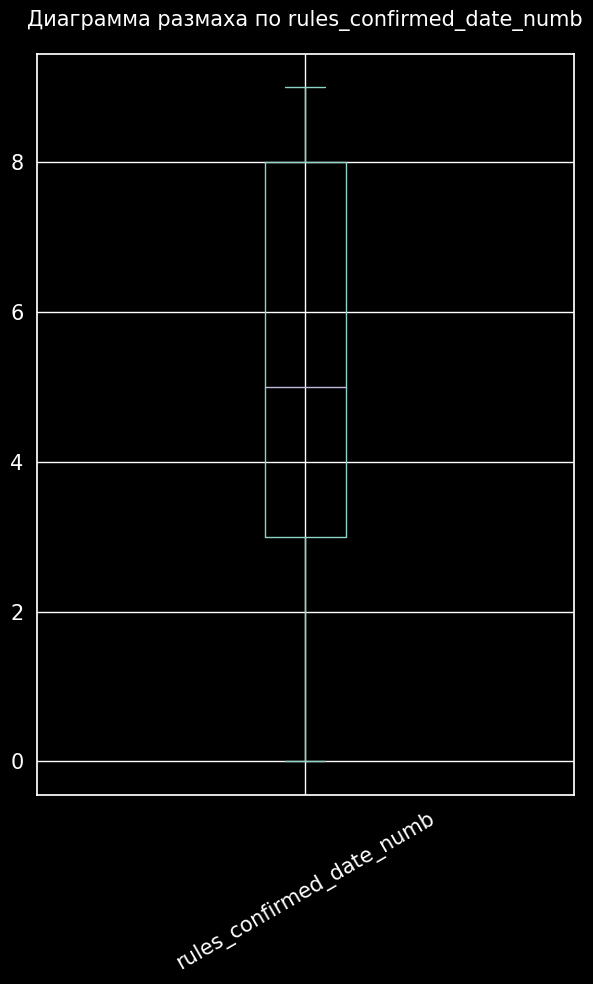

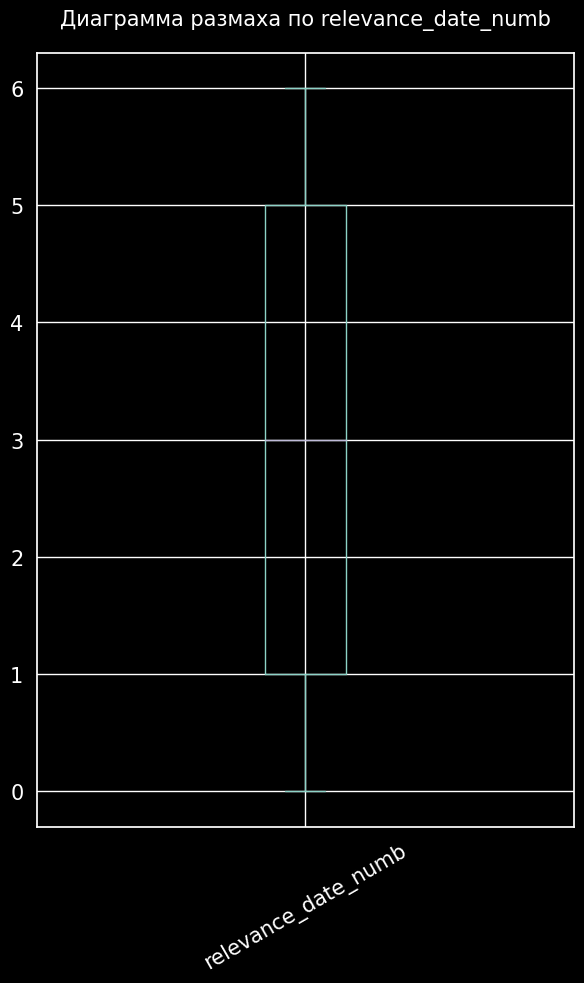

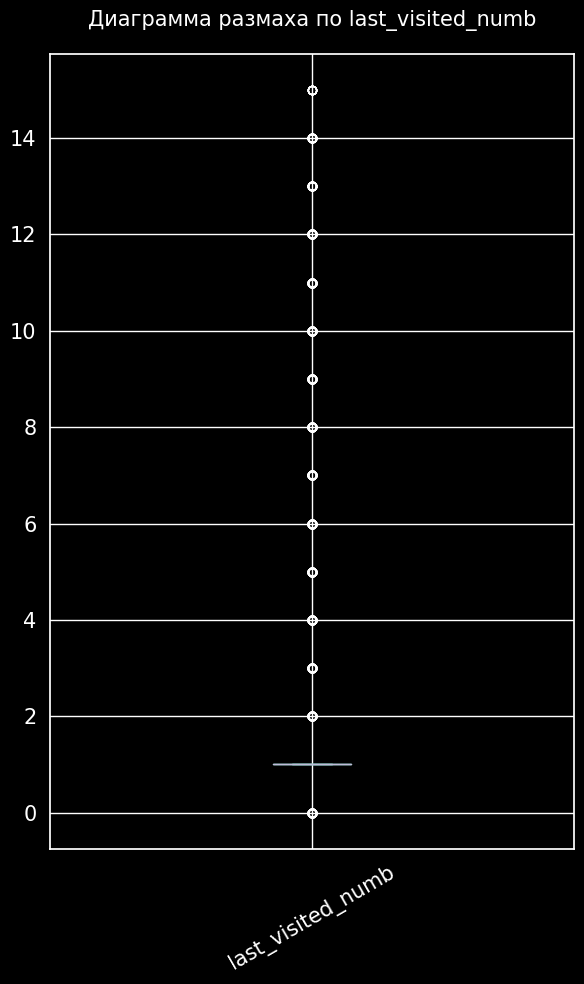

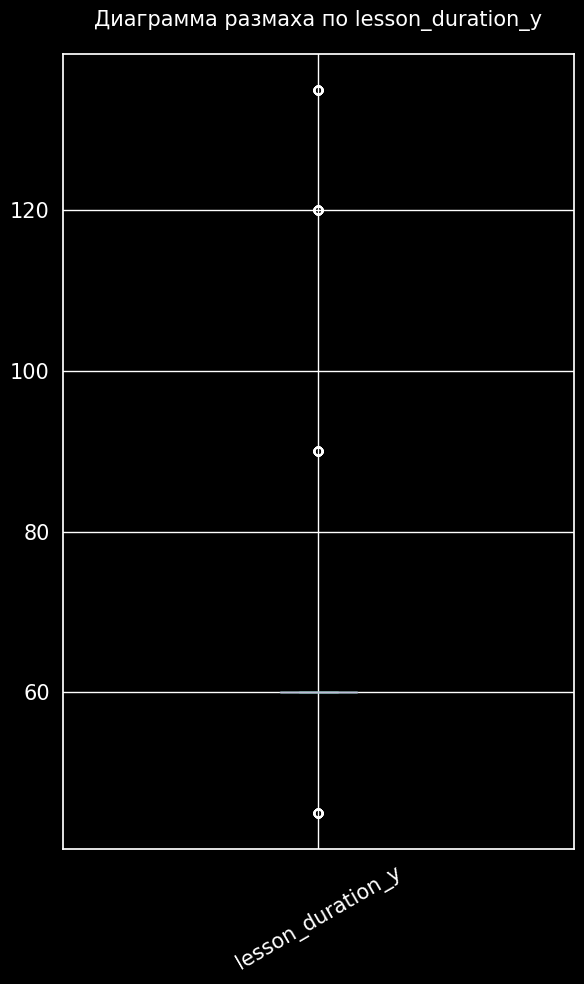

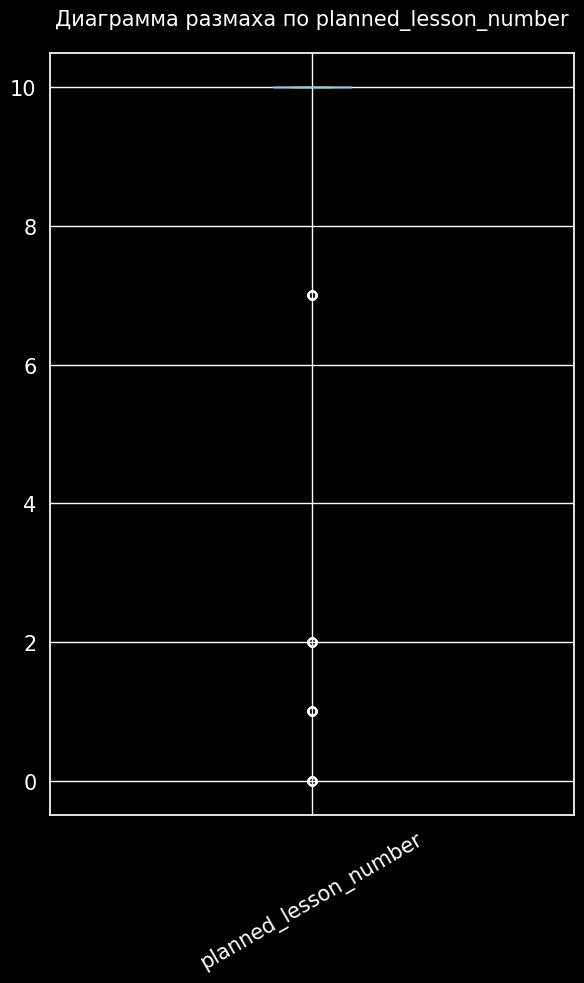

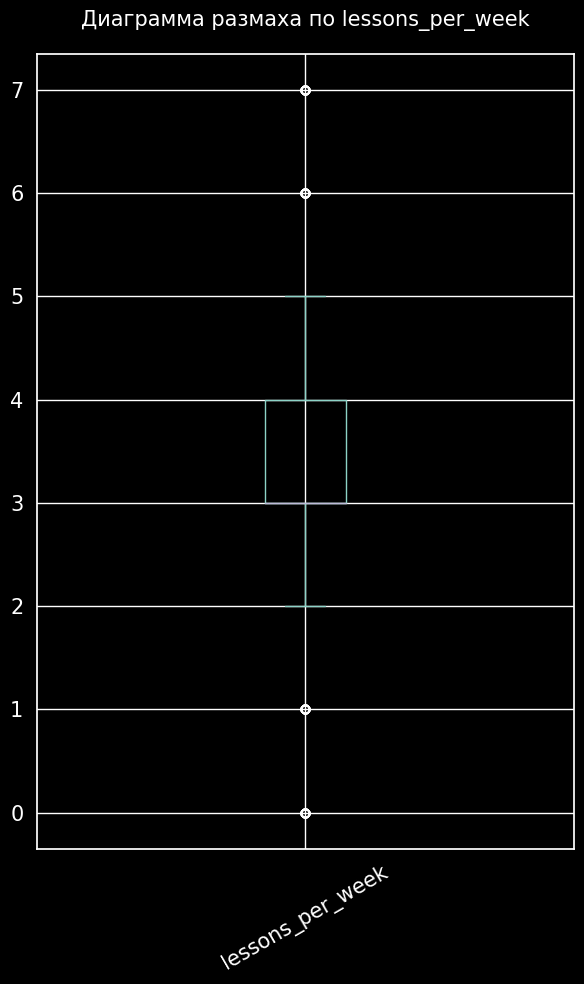

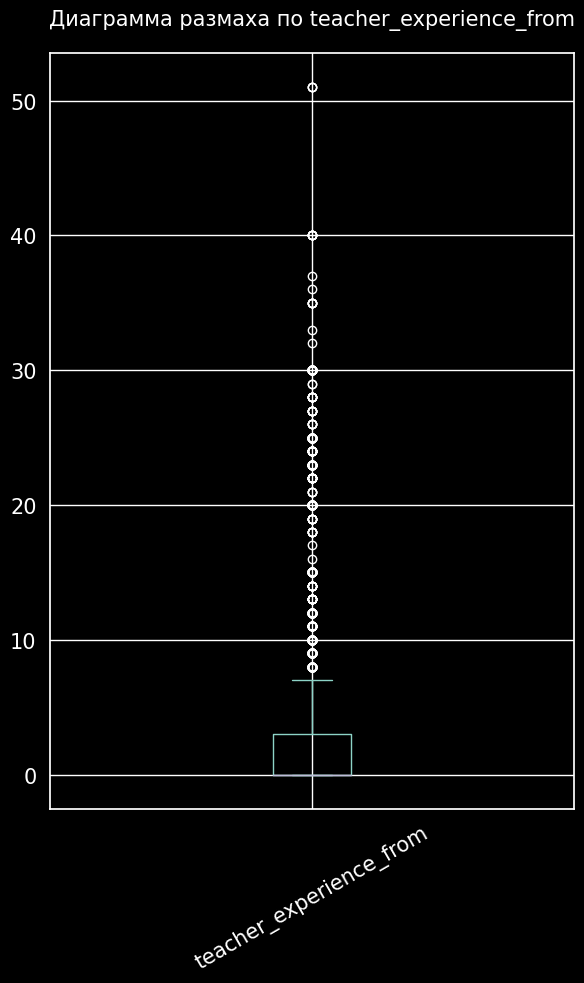

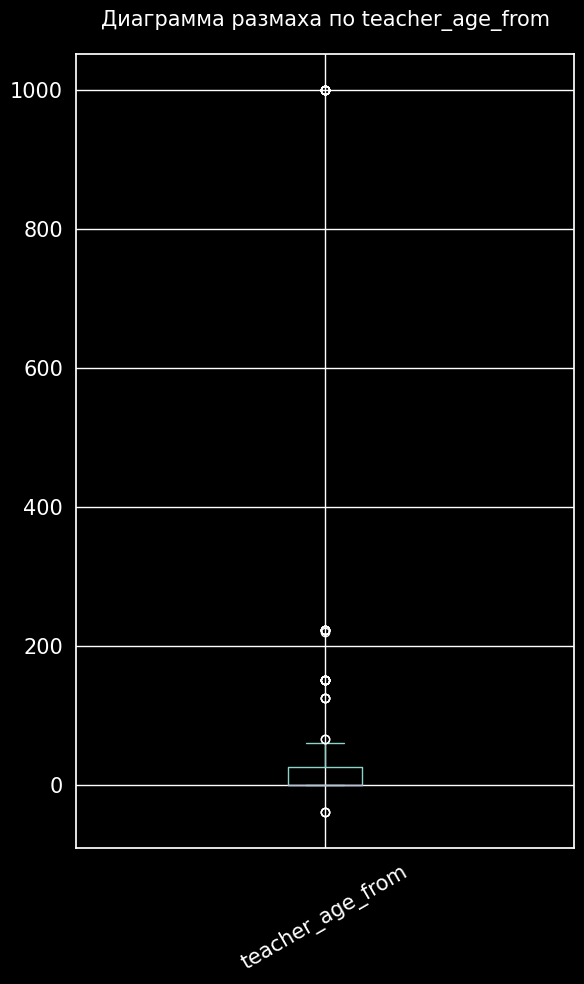

In [308]:
# Построим графики.

for m in ['display_days','star_rating','rating_for_users_yesterday','review_num','reg_date_numb','birth_date_numb','teaching_start_date_numb','rules_confirmed_date_numb','relevance_date_numb','last_visited_numb',
          'lesson_duration_y','planned_lesson_number','lessons_per_week','teacher_experience_from','teacher_age_from']:
  plt.figure(figsize=(6, 10))
  df[m].plot(kind="box").set_title(f'Диаграмма размаха по {m}', fontsize=15)
  plt.xticks(rotation=30, fontsize=15)
  plt.yticks(fontsize=15)
  plt.show()

In [311]:
# Посмотрим на выбросы поближе.

def cut_trash(column):
  q1 = np.quantile(df[column], 0.25)
  q3 = np.quantile(df[column], 0.75)
  iqr = q3 - q1
  left_whiskers = q1 - 1.5 * iqr
  right_whiskers = q3 + 1.5 * iqr
  total_trash_right= df.loc[df[column] > right_whiskers]
  total_trash_left= df.loc[df[column] < left_whiskers]
  return total_trash_right.index.to_list(),total_trash_left.index.to_list()

In [312]:
a,s = cut_trash('teacher_age_from')

In [317]:
df['teacher_age_from'].value_counts()

0       1638568
25       508213
30       152678
18       133769
16       133089
20        63326
23        59005
22        54214
24        37190
27        31854
35        23004
28        20482
26        19052
40        16266
21        12808
50        10507
19         8773
45         3589
29         1419
38          662
33          510
37          487
32          382
34          246
39          242
36          214
2           206
3           195
5           194
31          185
17          164
43          151
1           132
10          115
42           70
60           69
15           66
47           48
14           25
55           25
41           15
1000         10
150          10
4             9
6             9
8             8
48            8
222           7
46            6
44            6
124           4
54            4
-40           3
52            2
9             2
65            2
56            2
51            1
220           1
57            1
7             1
58            1
13      

In [319]:
df.loc[a,'teacher_age_from']= df['teacher_age_from'].apply(np.mean())

TypeError: _mean_dispatcher() missing 1 required positional argument: 'a'

In [315]:
df.loc[s,'teacher_age_from'].shape

(3,)